In [187]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

            ####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

a=6371.0e3
R=a

ncfile='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/aqua_isca5m/aqua_isca5m0.nc'
v_var=nc.Dataset(ncfile,'r')
sigma_full=v_var['pfull'][::-1]
sigma_half=v_var['phalf'][::-1]
lat_nc=v_var['lat']

#### Load files

In [188]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

m4   =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la4m_oc4m/*.hkl'))
m5   =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la5m_oc5m/*.hkl'))
m8   =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la8m_oc8m/*.hkl'))
m10  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la10m_oc10m/*.hkl'))
m12  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la12m_oc12m/*.hkl'))
m16  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la16m_oc16m/*.hkl'))
m20  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la20m_oc20m/*.hkl'))
m30  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la30m_oc30m/*.hkl'))
m50  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la50m_oc50m/*.hkl'))
m80  =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la80m_oc80m/*.hkl'))
m100 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la100m_oc100m/*.hkl'))
sea_ice = (glob.glob('/project2/tas1/pragallva/Summer_quarter_2018/post_process_data/seaice_isca_landice55_z0/*.hkl'))

#### Combine all depths

In [196]:
# DEPTHS       = [m4, m5, m8, m10, m12, m16, m20, m30, m50, m80, m100]#, sea_ice]
# depth_values = [4,   5,  8,  10,  12,  16,  20,  30,  50,  80,  100]#,     999]

DEPTHS       = [m5, m50]#, sea_ice]
depth_values = [5, 50]#,     999]
flux=[]
flux_vert=[]
div=[]
div_vert=[]
eke=[]
raw=[]
tsurf=[]
mmc_decomp=[]
mmc_decomp_vert=[]
tend_Wm2=[]
tend_PW=[]
c=5
coord=load(m5[c])
for depth in DEPTHS:          
        f=0; e=1; mmcv=2; r=3; fv=4; twm2=5; c=6; d=7; dv=8; mmc=9; tpw=10
        eke.append(load(depth[e]))
        mmc_decomp.append(load(depth[mmc]))
        mmc_decomp_vert.append(load(depth[mmcv]))
        raw.append(load(depth[r]))
        flux.append(load(depth[f]))
        flux_vert.append(load(depth[fv]))
        div.append(load(depth[d])) 
        div_vert.append(load(depth[dv]))
        tend_Wm2.append(load(depth[twm2]))
        tend_PW.append(load(depth[tpw]))
        

#### Load all net energy terms in PW

In [5]:
lat=div[0]['latn']
def M(X):
    #X=X-X.mean(axis=0)[None,:]
    return X
Iswabs=[]; Ishf=[]; Idhdt=[]; Iolr=[]; Ine=[];
ISW_sfc=[]; ISW_toa=[]; ILW_sfc=[]; Ishflx=[]; Ilhflx=[]; ISFC=[]; ITOA=[]; TS=[]; precip=[]
for depth in range(len(DEPTHS)):
#     print depth
    Iswabs.append(M(flux[depth]['SWABS']))
    Ishf.append(M(flux[depth]['SHF']))
    Idhdt.append(M(flux[depth]['dhdt']))
    Iolr.append(M(flux[depth]['olr']))
    ISW_sfc.append(-1*M(flux[depth]['SW_sfc_d'])) ## up
    ILW_sfc.append(M(-1*flux[depth]['LW_sfc_d'])) ## up
    ISW_toa.append(M(flux[depth]['SW_toa_d']))    ## dn
    Ishflx.append(M(flux[depth]['shflx_u']))      ## up
    Ilhflx.append(M(flux[depth]['lhflx_u']))      ## up    
    ISFC.append(M(flux[depth]['SFC_u']))
    ITOA.append(M(flux[depth]['TOA_d']))  
    precip.append(M(flux[depth]['precip']))  
    Ine.append(Iswabs[depth]+Ishf[depth]-Iolr[depth]-Idhdt[depth])

#### Load all tendency terms

In [6]:
print tend_PW[0].keys()
print tend_Wm2[0].keys()

['dmoistdt_vert', 'dsensdt', 'dhdt', 'dsensdt_vert', 'dpotdt_vert', 'dmoistdt', 'dpotdt', 'dhdt_vert']
['dmoistdt_vert', 'dsensdt', 'dhdt', 'dsensdt_vert', 'dpotdt_vert', 'dmoistdt', 'dpotdt', 'dhdt_vert']


In [7]:
lat=div[0]['latn']

Idsensdt=[]; Idmoistdt=[]; Idhdt=[]; Idpotdt=[]; 
dsensdt=[];  dmoistdt=[];  dhdt=[];  dpotdt=[]; 
for depth in range(len(DEPTHS)):
    Idsensdt.append(M(tend_PW[depth]['dsensdt']))
    Idmoistdt.append(M(tend_PW[depth]['dmoistdt']))
    Idpotdt.append(M(tend_PW[depth]['dpotdt']))
    Idhdt.append(M(tend_PW[depth]['dhdt']))
    
    dsensdt.append(M(tend_Wm2[depth]['dsensdt']))
    dmoistdt.append(M(tend_Wm2[depth]['dmoistdt']))
    dpotdt.append(M(tend_Wm2[depth]['dpotdt']))
    dhdt.append(M(tend_Wm2[depth]['dhdt']))


#### Load all MSE transport in PW

In [8]:
TE=[]; MM=[]; SE=[]; INE=[]; EKE_vert=[]; EMF_vert=[]; TEv=[]; MMv=[]; SEv=[]; NEv=[]
TE_pot=[];TE_sens=[];TE_moist=[];SE_pot=[];SE_sens=[];SE_moist=[];MM_pot=[];MM_sens=[];MM_moist=[];
for depth in range(len(DEPTHS)):
    TE.append(M(flux[depth]['TE']))
    SE.append(M(flux[depth]['SE']))
    MM.append(M(flux[depth]['MM']))
#     TE_pot.append(M(flux[depth]['TE_pot']))
    SE_pot.append(M(flux[depth]['SE_pot']))
    MM_pot.append(M(flux[depth]['MM_pot']))
    TE_moist.append(M(flux[depth]['TE_moist']))
    SE_moist.append(M(flux[depth]['SE_moist']))
    MM_moist.append(M(flux[depth]['MM_moist']))
    TE_sens.append(M(flux[depth]['TE_sens']))
    SE_sens.append(M(flux[depth]['SE_sens']))
    MM_sens.append(M(flux[depth]['MM_sens']))
    INE.append(TE[depth]+SE[depth]+MM[depth])
    MMv.append(M(flux_vert[depth]['MM']))
    SEv.append(M(flux_vert[depth]['SE']))
    TEv.append(M(flux_vert[depth]['TE']))
    NEv.append(M(flux_vert[depth]['NE']))
    TE_pot.append(TE[depth]-(TE_moist[depth]+TE_sens[depth]))

#     if (depth < len(DEPTHS)-1) :
    EKE_vert.append(eke[depth]['EKE_vert'])
    EMF_vert.append(eke[depth]['EMF_vert'])

#### Load all raw data

In [9]:
Cp=1000; L=2260*1000; g=10
Z=[]; q=[]; U=[]; T=[]; V=[]; MSE=[];
for depth in range(len(DEPTHS)):
    Z.append(M(raw[depth]['Z']))
    q.append(M(raw[depth]['q']))
    U.append(M(raw[depth]['U']))
    T.append(M(raw[depth]['T']))
    MSE.append(M(raw[depth]['MSE']))

#### Integrate function

In [10]:
import scipy.integrate as integrate
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1,:]+int_x[::-1,:][1:,:])/2
    return avg_int_r/10**15

#### Load terms in $Wm^{-2}$

In [11]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[]; div_TEv=[]; div_MMv=[]; div_SEv=[]; div_NEv=[]
swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];
SW_sfc=[]; SW_toa=[]; LW_sfc=[]; shflx=[]; lhflx=[]; sfc=[]; toa=[]
div_TE_pot=[];div_TE_sens=[];div_TE_moist=[];
div_SE_pot=[];div_SE_sens=[];div_SE_moist=[];
div_MM_pot=[];div_MM_sens=[];div_MM_moist=[];

for depth in range(len(DEPTHS)):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
    
#     div_TE_pot.append(M(div[depth]['TE_pot']))
    div_SE_pot.append(M(div[depth]['SE_pot']))
    div_MM_pot.append(M(div[depth]['MM_pot']))
    div_TE_moist.append(M(div[depth]['TE_moist']))
    div_SE_moist.append(M(div[depth]['SE_moist']))
    div_MM_moist.append(M(div[depth]['MM_moist']))
    div_TE_sens.append(M(div[depth]['TE_sens']))
    div_SE_sens.append(M(div[depth]['SE_sens']))
    div_MM_sens.append(M(div[depth]['MM_sens']))
    
    div_TE_pot.append(div_TE[depth]-(div_TE_moist[depth]+div_TE_sens[depth]))

        
    div_TEv.append(div_vert[depth]['TE'])
    div_SEv.append(div_vert[depth]['SE'])
    div_MMv.append(div_vert[depth]['MM'])
    div_NEv.append(div_vert[depth]['NE'])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
    SW_sfc.append(-1*div[depth]['SW_sfc_d'])
    LW_sfc.append(-1*div[depth]['LW_sfc_d'])
    SW_toa.append(div[depth]['SW_toa_d'])
    shflx.append(div[depth]['shflx_u'])
    lhflx.append(div[depth]['lhflx_u'])
    sfc.append(div[depth]['SFC_u'])
    toa.append(div[depth]['TOA_d'])    

# Average Northern and Southern Hemispheres

In [12]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE); EKE_vert=np.array(EKE_vert); EMF_vert=np.array(EMF_vert)
TE_pot=np.array(TE_pot);TE_sens=np.array(TE_sens);TE_moist=np.array(TE_moist);
SE_pot=np.array(SE_pot);SE_sens=np.array(SE_sens);SE_moist=np.array(SE_moist);
MM_pot=np.array(MM_pot);MM_sens=np.array(MM_sens);MM_moist=np.array(MM_moist);
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
ISW_sfc=np.array(ISW_sfc); ILW_sfc=np.array(ILW_sfc); ISW_toa=np.array(ISW_toa); Ishflx=np.array(Ishflx); Ilhflx=np.array(Ilhflx);
ISFC=np.array(ISFC); ITOA=np.array(ITOA); TS=np.array(TS)
TEv=np.array(TEv); SEv=np.array(SEv); MMv=np.array(MMv); NEv=np.array(NEv)
div_TEv=np.array(div_TEv); div_SEv=np.array(div_SEv); div_MMv=np.array(div_MMv); div_NEv=np.array(div_NEv)
Z=np.array(Z); q=np.array(q); U=np.array(U); T=np.array(T); V=np.array(V); MSE=np.array(MSE);
precip=np.array(precip)
Idsensdt=np.array(Idsensdt) ; Idmoistdt=np.array(Idmoistdt); Idpotdt=np.array(Idpotdt); Idhdt=np.array(Idhdt);
dsensdt=np.array(dsensdt)   ; dmoistdt=np.array(dmoistdt); dpotdt=np.array(dpotdt); dhdt=np.array(dhdt);

In [13]:
def integrated(x):
    
    l=np.deg2rad(lat[:,None])

    def A(X):
        Y=(X-np.average(X, axis=0, weights=np.cos(np.deg2rad(lat)))[None,:])
        return Y

    x=A(x)
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1,:])#int_x[::-1,:][1:,:]+/2.0
    return avg_int_r/10**15

Iprecip = np.copy(ISFC)
for d in range(len(DEPTHS)):
    Iprecip[d,...] = integrated(precip[d,...])
     
    

In [14]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[...,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [15]:
Iswabs.shape

(2, 1739, 12)

In [16]:
TE_a   ,SE_a     , MM_a  , NE_a  , EMF_vert_a,   lat_a  = N_S_avg(TE, SE, MM, NE, EMF_vert, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a, Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr, Idhdt, lat[1:-1] )
ISW_sfc_a, ILW_sfc_a  , ISW_toa_a , Ishflx_a, Ilhflx_a, latr_a = N_S_avg( ISW_sfc,ILW_sfc,ISW_toa, Ishflx, Ilhflx, lat[1:-1] )
ISFC_a, Iprecip_a  = N_S_avg( ISFC,Iprecip,ISFC,ISFC,ISFC, lat[1:-1] )[0:2]
ITOA_a = N_S_avg( ITOA,ITOA,ITOA,ITOA,ITOA, lat[1:-1] )[0]
EKE_vert_a  = N_S_avg( EKE_vert  ,EKE_vert,EKE_vert ,EKE_vert ,EKE_vert , lat, flux_flag=1 )[0]

TEv_a  ,SEv_a    , MMv_a  , NEv_a    ,ignore,  lat_a = N_S_avg(TEv, SEv, MMv, NEv,NEv, lat)
CpTv_a ,gZv_a    , Lqv_a  , MSEv_a   ,precip_a,  lat_a = N_S_avg(Cp*T, g*Z, L*q, Cp*T+g*Z+L*q, precip, lat, 1)

TE_sens_a  ,SE_sens_a   , MM_sens_a  , TE_moist_a  , SE_moist_a,   lat_a  = N_S_avg(TE_sens, SE_sens, MM_sens, TE_moist, SE_moist, lat)
TE_pot_a   ,SE_pot_a    , MM_pot_a   , MM_moist_a  , ignore,   lat_a      = N_S_avg(TE_pot,   SE_pot,  MM_pot, MM_moist, SE_moist, lat)

Idsensdt_a, Idmoistdt_a  , Idpotdt_a , Idhdt_a, ignore, latr_a = N_S_avg( Idsensdt, Idmoistdt , Idpotdt , Idhdt, Idhdt, lat[1:-1] )
dsensdt_a,  dmoistdt_a  ,  dpotdt_a ,  dhdt_a,  ignore, lat_a  = N_S_avg( dsensdt,  dmoistdt  ,  dpotdt , dhdt,  dhdt, lat, flux_flag=1)


In [ ]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div_vert(x):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(13):
            div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div


div_CpT=spher_div_vert(CpTv_a)
div_gZ=spher_div_vert(gZv_a)
div_Lq=spher_div_vert(Lqv_a)
div_MSE=spher_div_vert(MSEv_a)

# div_TEv_a, div_SEv_a, div_MMv_a, div_NEv_a,ignore,lat_a = N_S_avg(div_TEv, div_SEv, div_MMv, div_NEv,div_NEv, lat,flux_flag=1)

#### Calculate divergence

In [18]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x,fac=1):
       N=100
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(x.shape[0]):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a=spher_div(TE_a*10**15)
div_SE_a=spher_div(SE_a*10**15)
div_MM_a=spher_div(MM_a*10**15)
div_NE_a=div_TE_a+div_SE_a+div_MM_a
div_EMF_vert_a=spher_div(EMF_vert_a*10**10, np.cos(np.radians(lat_a)) )

div_TE_moist_a=spher_div(TE_moist_a*10**15)
div_SE_moist_a=spher_div(SE_moist_a*10**15)
div_MM_moist_a=spher_div(MM_moist_a*10**15)

div_TE_pot_a=spher_div(TE_pot_a*10**15)
div_SE_pot_a=spher_div(SE_pot_a*10**15)
div_MM_pot_a=spher_div(MM_pot_a*10**15)

div_TE_sens_a=spher_div(TE_sens_a*10**15)
div_SE_sens_a=spher_div(SE_sens_a*10**15)
div_MM_sens_a=spher_div(MM_sens_a*10**15)


#### Find the storm track position

In [19]:
lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
      for m in range(0,13):           
            l_range=((lat_a>=30) & (lat_a<=60))                
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)
storm_pos_dse=find_zero((div_TE_sens_a+div_TE_pot_a))

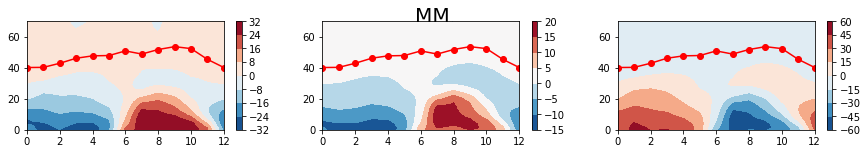

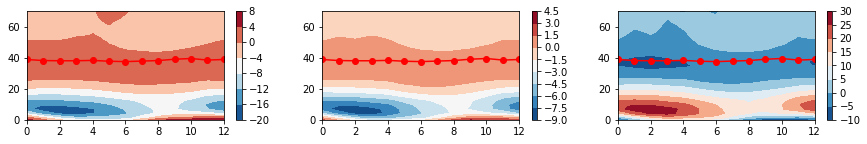

In [20]:
d=0
l_range=((lat_a>=00) & (lat_a<=70)) 
py.figure(figsize=(15,2))
py.subplot(1,3,1)
py.contourf(range(13), lat_a[l_range], (MM_sens_a)[d,l_range,...],   cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,2)
py.contourf(range(13), lat_a[l_range], (MM_moist_a)[d,l_range,...],  cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,3)
py.contourf(range(13), lat_a[l_range], (MM_pot_a)[d,l_range,...],  cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.suptitle("MM",fontsize=20)

d=1
l_range=((lat_a>=00) & (lat_a<=70)) 
py.figure(figsize=(15,2))
py.subplot(1,3,1)
py.contourf(range(13), lat_a[l_range], MM_sens_a[d,l_range,...],   cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,2)
py.contourf(range(13), lat_a[l_range], (MM_moist_a)[d,l_range,...],  cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,3)
py.contourf(range(13), lat_a[l_range], (MM_pot_a)[d,l_range,...],  cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')

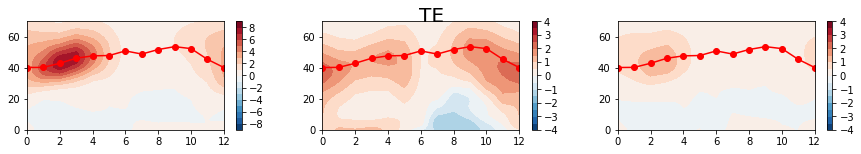

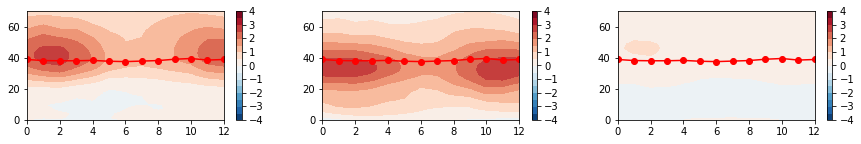

In [21]:
d=0
l_range=((lat_a>=00) & (lat_a<=70)) 
py.figure(figsize=(15,2))
py.subplot(1,3,1)
py.contourf(range(13), lat_a[l_range], (TE_sens_a)[d,l_range,...],  np.arange(-9,10,1),  cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,2)
py.contourf(range(13), lat_a[l_range], (TE_moist_a)[d,l_range,...], np.arange(-4,4.5,0.5),  cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,3)
py.contourf(range(13), lat_a[l_range], (TE_pot_a)[d,l_range,...],   np.arange(-4,4.5,0.5), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.suptitle("TE",fontsize=20)


d=1
# l_range=((lat_a>=35) & (lat_a<=70)) 
py.figure(figsize=(15,2))
py.subplot(1,3,1)
py.contourf(range(13), lat_a[l_range], (TE_sens_a)[d,l_range,...], np.arange(-4,4.5,0.5), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,2)
py.contourf(range(13), lat_a[l_range], (TE_moist_a)[d,l_range,...], np.arange(-4,4.5,0.5), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,3)
py.contourf(range(13), lat_a[l_range], (TE_pot_a)[d,l_range,...],  np.arange(-4,4.5,0.5),   cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')


In [22]:
Ilhflx_a.shape

(2, 870, 13)

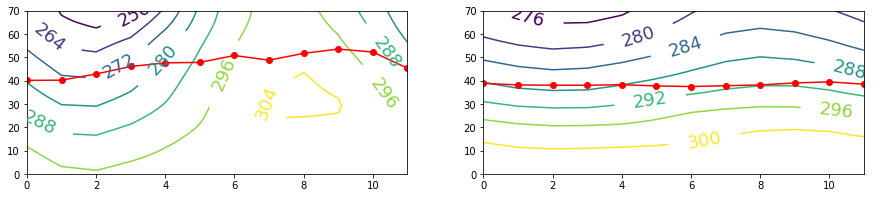

In [23]:
py.figure(figsize=(15,3))
py.subplot(1,2,1)
l_range=((lat>=00) & (lat<=70)) 
c=py.contour(range(12),lat[l_range],raw[0]['T'][l_range,0,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)

py.plot(storm_pos[0,:-1],'ro-')

py.subplot(1,2,2)
l_range=((lat>=00) & (lat<=70)) 
c=py.contour(range(12),lat[l_range],raw[1]['T'][l_range,0,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[1,:-1],'ro-')

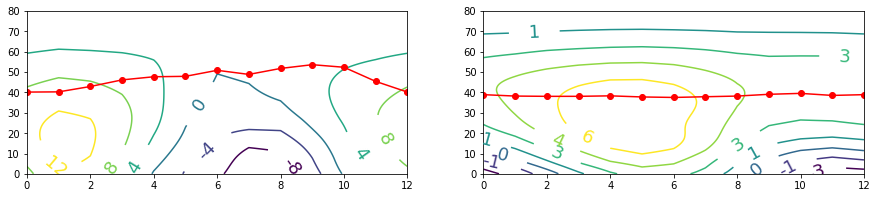

In [24]:
py.figure(figsize=(15,3))
py.subplot(1,2,1)
l_range=((lat_a[:-1]>=00) & (lat_a[:-1]<=80)) 
c=py.contour(range(13),lat_a[:-1][l_range],Ilhflx_a[0,l_range,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[0,:],'ro-')

py.subplot(1,2,2)
l_range=((lat_a[:-1]>=00) & (lat_a[:-1]<=80)) 
c=py.contour(range(13),lat_a[:-1][l_range],Ilhflx_a[1,l_range,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[1,:],'ro-')


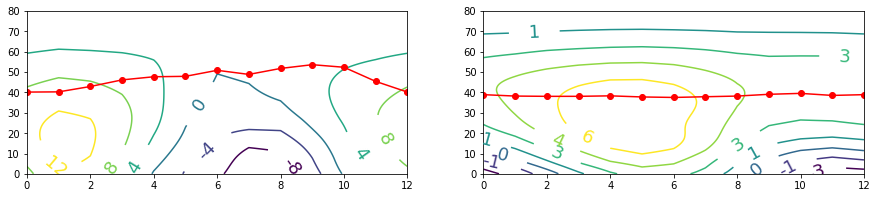

In [25]:
py.figure(figsize=(15,3))
py.subplot(1,2,1)
l_range=((lat_a[:-1]>=00) & (lat_a[:-1]<=80)) 
c=py.contour(range(13),lat_a[:-1][l_range],Ilhflx_a[0,l_range,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[0,:],'ro-')

py.subplot(1,2,2)
l_range=((lat_a[:-1]>=00) & (lat_a[:-1]<=80)) 
c=py.contour(range(13),lat_a[:-1][l_range],Ilhflx_a[1,l_range,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[1,:],'ro-')


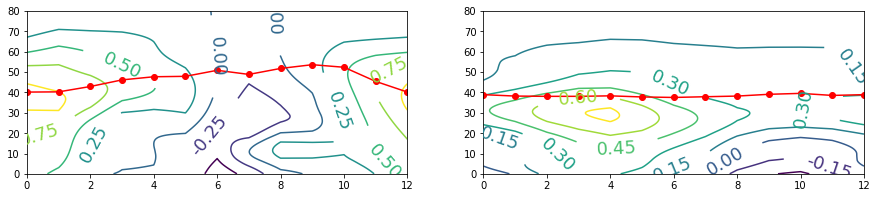

In [26]:

py.figure(figsize=(15,3))
py.subplot(1,2,1)
l_range=((lat_a[:-1]>=00) & (lat_a[:-1]<=80)) 
c=py.contour(range(13),lat_a[:-1][l_range],Ishflx_a[0,l_range,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[0,:],'ro-')

py.subplot(1,2,2)
l_range=((lat_a[:-1]>=00) & (lat_a[:-1]<=80)) 
c=py.contour(range(13),lat_a[:-1][l_range],Ishflx_a[1,l_range,:]); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[1,:],'ro-')

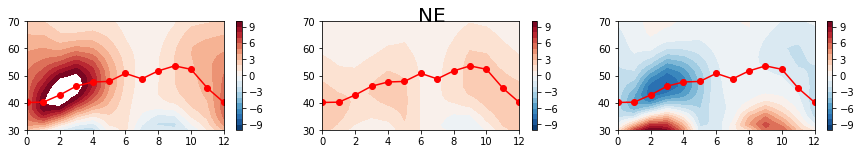

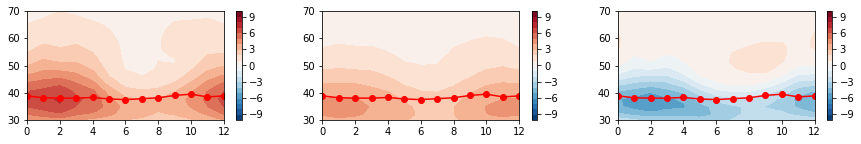

In [27]:
d=0
l_range=((lat_a>=30) & (lat_a<=70)) 
py.figure(figsize=(15,2))
py.subplot(1,3,1)
py.contourf(range(13), lat_a[l_range], (MM_sens_a+SE_sens_a+TE_sens_a)[d,l_range,...],  np.arange(-10,11,1), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,2)
py.contourf(range(13), lat_a[l_range], (MM_moist_a+SE_moist_a+TE_moist_a)[d,l_range,...], np.arange(-10,11,1), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,3)
py.contourf(range(13), lat_a[l_range], (MM_pot_a+SE_pot_a+TE_pot_a)[d,l_range,...], np.arange(-10,11,1), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.suptitle("NE",fontsize=20)

d=1
l_range=((lat_a>=30) & (lat_a<=70)) 
py.figure(figsize=(15,2))
py.subplot(1,3,1)
py.contourf(range(13), lat_a[l_range], (MM_sens_a+SE_sens_a+TE_sens_a)[d,l_range,...],  np.arange(-10,11,1), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,2)
py.contourf(range(13), lat_a[l_range], (MM_moist_a+SE_moist_a+TE_moist_a)[d,l_range,...], np.arange(-10,11,1), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')
py.subplot(1,3,3)
py.contourf(range(13), lat_a[l_range], (MM_pot_a+SE_pot_a+TE_pot_a)[d,l_range,...], np.arange(-10,11,1), cmap=cm.RdBu_r); py.colorbar()
py.plot(storm_pos[d,:],'ro-')


In [28]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat, X=storm_pos):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)

I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)

## Dry static energy budget

In [156]:
Idsensdt_a, Idmoistdt_a  , Idpotdt_a , Idhdt_a, ignore, latr_a = N_S_avg( Idsensdt, Idmoistdt , Idpotdt , Idhdt, Idhdt, lat[1:-1] )
dsensdt_a,  dmoistdt_a  ,  dpotdt_a ,  dhdt_a,  ignore, lat_a  = N_S_avg( dsensdt,  dmoistdt  ,  dpotdt , dhdt,  dhdt, lat, flux_flag=1)

swabs=np.array(swabs); shf=np.array(shf); ne=np.array(ne); olr=np.array(olr); dhdt=np.array(dhdt);
SW_sfc=np.array(SW_sfc); LW_sfc=np.array(LW_sfc); SW_toa=np.array(SW_toa); shflx=np.array(shflx); lhflx=np.array(lhflx);
sfc=np.array(sfc); toa=np.array(toa); 

SWABS_a, SHF_a, FNE_a, OLR_a, dhdt_a, lat_a = N_S_avg( swabs,shf, ne ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#
sfc_a, toa_a = N_S_avg( sfc, toa, shflx, lhflx, LW_sfc, lat,flux_flag=1)[0:2]


In [152]:
ILP_a = L*Iprecip_a/(24.0*60.0*60.0)

div_TE_dse_a = div_TE_pot_a + div_TE_sens_a
div_SE_dse_a = div_SE_pot_a + div_SE_sens_a
div_MM_dse_a = div_MM_pot_a + div_MM_sens_a

ITE_dse_a  = TE_a - (TE_moist_a) #+ TE_sens_a
ISE_dse_a  = SE_pot_a + SE_sens_a
IMM_dse_a  = MM_pot_a + MM_sens_a
INE_dse_a1 = ITE_dse_a + ISE_dse_a + IMM_dse_a
IdLqdt_a   =  Idmoistdt_a
INE_dse_a  = (Iswabs_a + (Ishf_a - Ilhflx_a) - Iolr_a  + ILP_a - (Idsensdt_a)) 

## Moisture equation PW
###### $d(Lq)/dt$         = Idmoistdt_a
###### $\nabla.(Lqv)$     = (TE_moist_a+SE_moist_a+MM_moist_a)
###### L(E-P)             =  Ilhflx_a - ILP_a

## Moisture equation Wm^2
###### $d(Lq)/dt$          = dmoistdt_a
###### $\nabla.(Lqv)$      = (div_TE_a+div_SE_a+div_MM_a)
###### L(E-P)              =  lhflx_a - L*precip_a/(24.0*60.0*60.0)

In [129]:
LP_a=L*precip_a/(24.0*60.0*60.0)

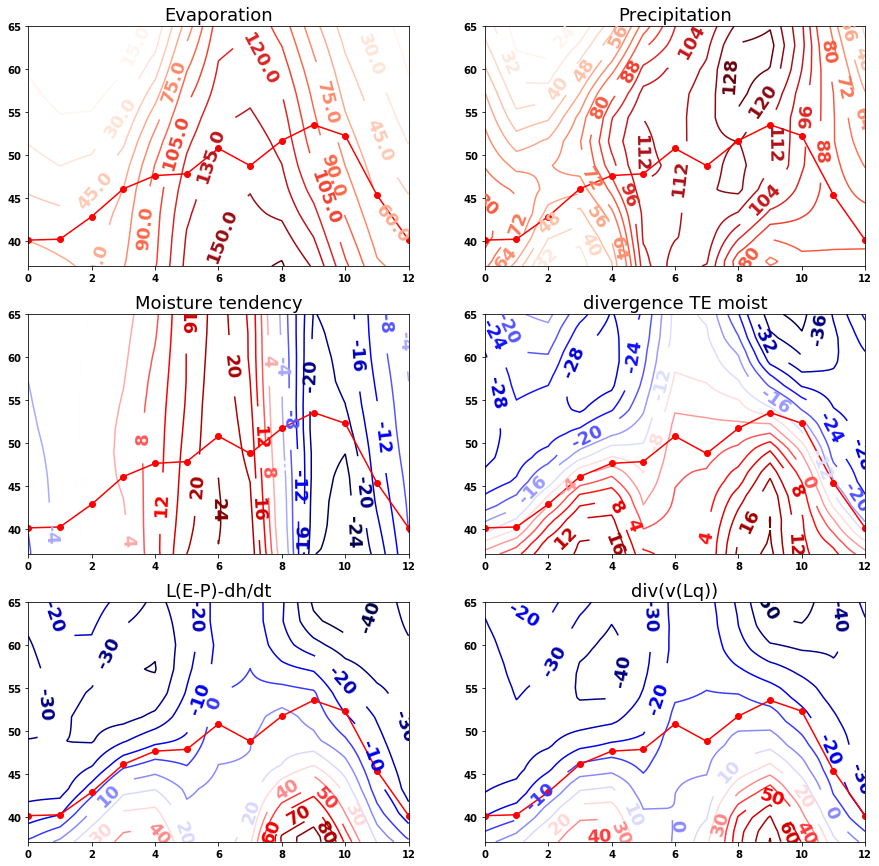

In [142]:
py.figure(figsize=(15,15))
d=0
py.subplot(3,2,1)
l_range=((lat_a>=37) & (lat_a<=65)) 
c=py.contour(range(13),lat_a[l_range],lhflx_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Evaporation",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),lat_a[l_range],LP_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),lat_a[l_range],(dmoistdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Moisture tendency",fontsize=18)

py.subplot(3,2,4)
c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a))[d,l_range,:],  15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("divergence TE moist",fontsize=18)

py.subplot(3,2,5)
c=py.contour(range(13),lat_a[l_range],(lhflx_a-LP_a-dmoistdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L(E-P)-dh/dt",fontsize=18)

py.subplot(3,2,6)
c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a+div_MM_moist_a+div_SE_moist_a))[d,l_range,:],  15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("div(v(Lq))",fontsize=18)


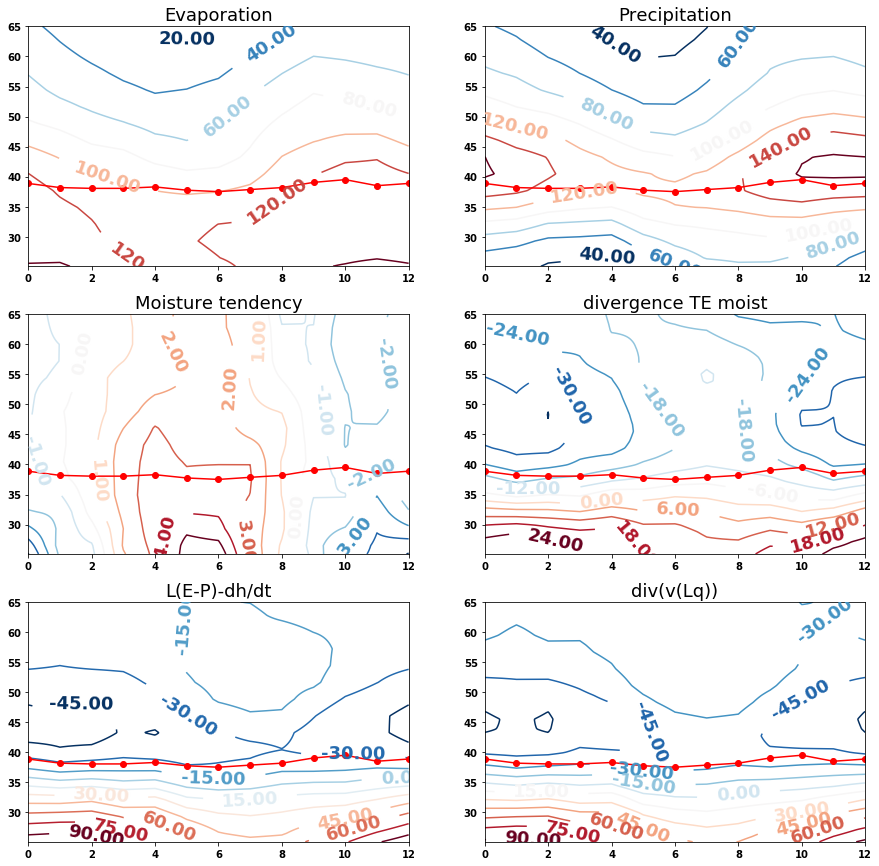

In [183]:
py.figure(figsize=(15,15))
d=1
py.subplot(3,2,1)
l_range=((lat_a>=25) & (lat_a<=65)) 
c=py.contour(range(13),lat_a[l_range],lhflx_a[d,l_range,:], cmap=cm.RdBu_r); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Evaporation",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),lat_a[l_range],LP_a[d,l_range,:], cmap=cm.RdBu_r); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),lat_a[l_range],(dmoistdt_a)[d,l_range,:], 10, cmap=cm.RdBu_r); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Moisture tendency",fontsize=18)

py.subplot(3,2,4)
c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a))[d,l_range,:],  10, cmap=cm.RdBu_r); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("divergence TE moist",fontsize=18)

py.subplot(3,2,5)
c=py.contour(range(13),lat_a[l_range],(lhflx_a-LP_a-dmoistdt_a)[d,l_range,:], 10, cmap=cm.RdBu_r); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L(E-P)-dh/dt",fontsize=18)

py.subplot(3,2,6)
c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a+div_MM_moist_a+div_SE_moist_a))[d,l_range,:],  10, cmap=cm.RdBu_r); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.2f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("div(v(Lq))",fontsize=18)


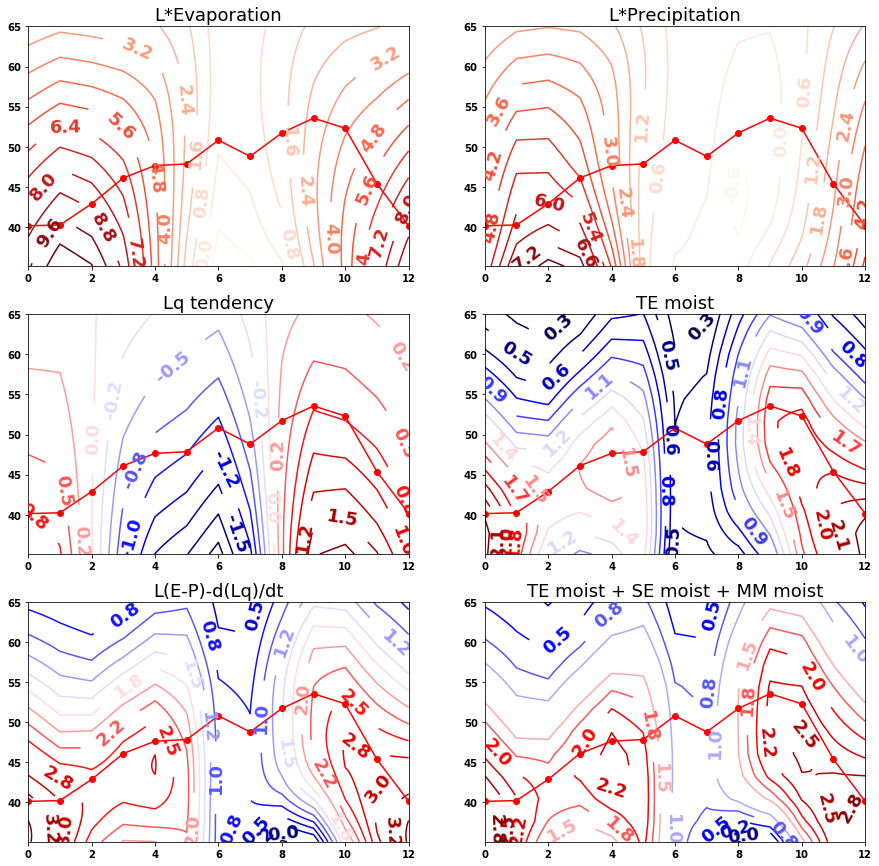

In [186]:
py.figure(figsize=(15,15))
d=0
py.subplot(3,2,1)
l_range=((latr_a>=35) & (latr_a<=65)) 
l_range1=((lat_a>=35) & (lat_a<=65)) 
c=py.contour(range(13),latr_a[l_range],Ilhflx_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L*Evaporation",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),latr_a[l_range],ILP_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L*Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),latr_a[l_range],(Idmoistdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Lq tendency",fontsize=18)

py.subplot(3,2,4)
c=py.contour(range(13),lat_a[l_range1],((TE_moist_a))[d,l_range1,:],  15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("TE moist",fontsize=18)

py.subplot(3,2,5)
c=py.contour(range(13),latr_a[l_range],(Ilhflx_a-ILP_a-Idmoistdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L(E-P)-d(Lq)/dt",fontsize=18)

py.subplot(3,2,6)
c=py.contour(range(13),lat_a[l_range1],((TE_moist_a+MM_moist_a+SE_moist_a))[d,l_range1,:],  15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("TE moist + SE moist + MM moist",fontsize=18)



## DSE equation PW
###### $d(CpT+gZ)/dt$       = Idsensdt_a
###### $\nabla.(CpT+gZ)$    = (ITE_dse_a+ISE_dse_a+IMM_dse_a)
###### $F_{R}+F_{B}+F_{Ql}$ = (Iswabs_a + (Ishf_a - Ilhflx_a) - Iolr_a  + ILP_a) 

## DSE equation Wm^2
###### $d(CpT+gZ)/dt$       = dsensdt_a
###### $\nabla.(CpT+gZ)$    = (div_TE_dse_a+div_SE_dse_a+div_MM_dse_a)
###### $F_{R}+F_{B}+F_{Ql}$ = (swabs_a + (shf_a - lhflx_a) - olr_a  + LP_a) 

In [ ]:
SWABS_a, SHF_a, FNE_a, OLR_a, dhdt_a, lat_a = N_S_avg( swabs,shf, ne ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#
sfc_a, toa_a = N_S_avg( sfc, toa, shflx, lhflx, LW_sfc, lat,flux_flag=1)[0:2]


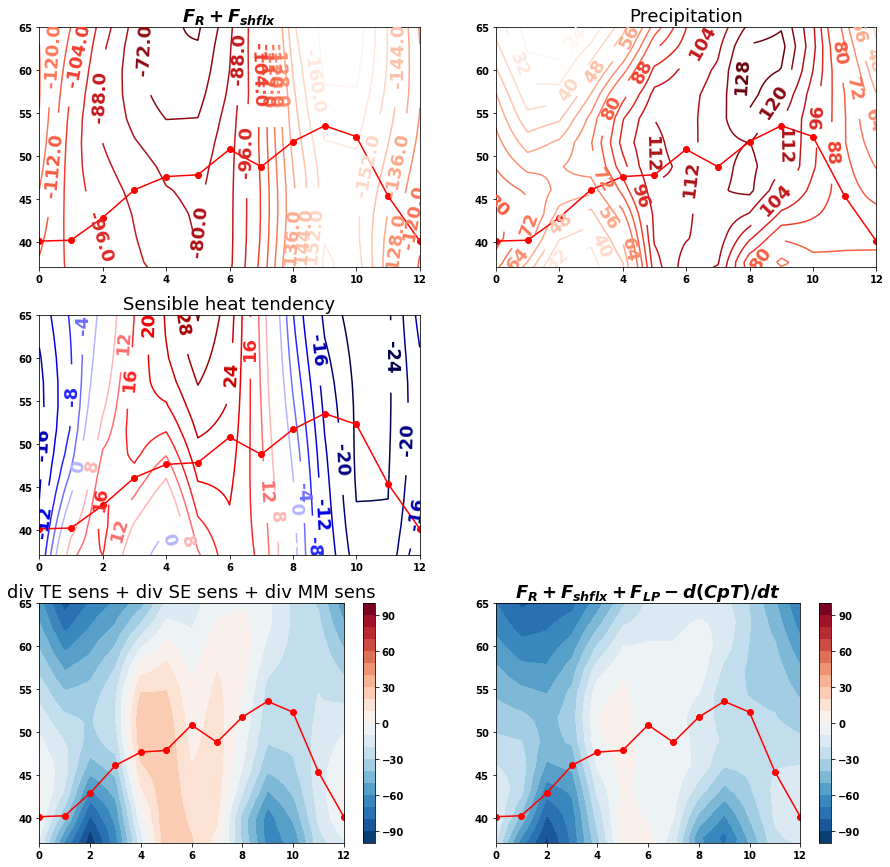

In [165]:
py.figure(figsize=(15,15))
d=0
py.subplot(3,2,1)
l_range=((lat_a>=37) & (lat_a<=65)) 
c=py.contour(range(13),lat_a[l_range],((SWABS_a + (SHF_a - lhflx_a) - OLR_a))[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title(r"$F_{R} + F_{shflx}$",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),lat_a[l_range],LP_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),lat_a[l_range],(dsensdt_a-dpotdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Sensible heat tendency",fontsize=18)

py.subplot(3,2,5)
c=py.contourf(range(13),lat_a[l_range],((div_TE_dse_a+div_SE_dse_a+div_MM_dse_a))[d,l_range,:],  np.arange(-100,110,10), cmap=cm.RdBu_r); py.colorbar()
#py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("div TE sens + div SE sens + div MM sens",fontsize=18)

py.subplot(3,2,6)
c=py.contourf(range(13),lat_a[l_range],(((SWABS_a + (SHF_a - lhflx_a) - OLR_a + LP_a))-dsensdt_a)[d,l_range,:], np.arange(-100,110,10), cmap=cm.RdBu_r); py.colorbar()
#py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title(r"$F_{R} + F_{shflx} + F_{LP} - d(CpT)/dt $",fontsize=18)

# py.subplot(3,2,6)
# c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a+div_MM_moist_a+div_SE_moist_a))[d,l_range,:],  15, cmap=cm.seismic); #py.colorbar()
# py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
# py.plot(storm_pos[d,:],'ro-')
# py.title("div(v(Lq))",fontsize=18)


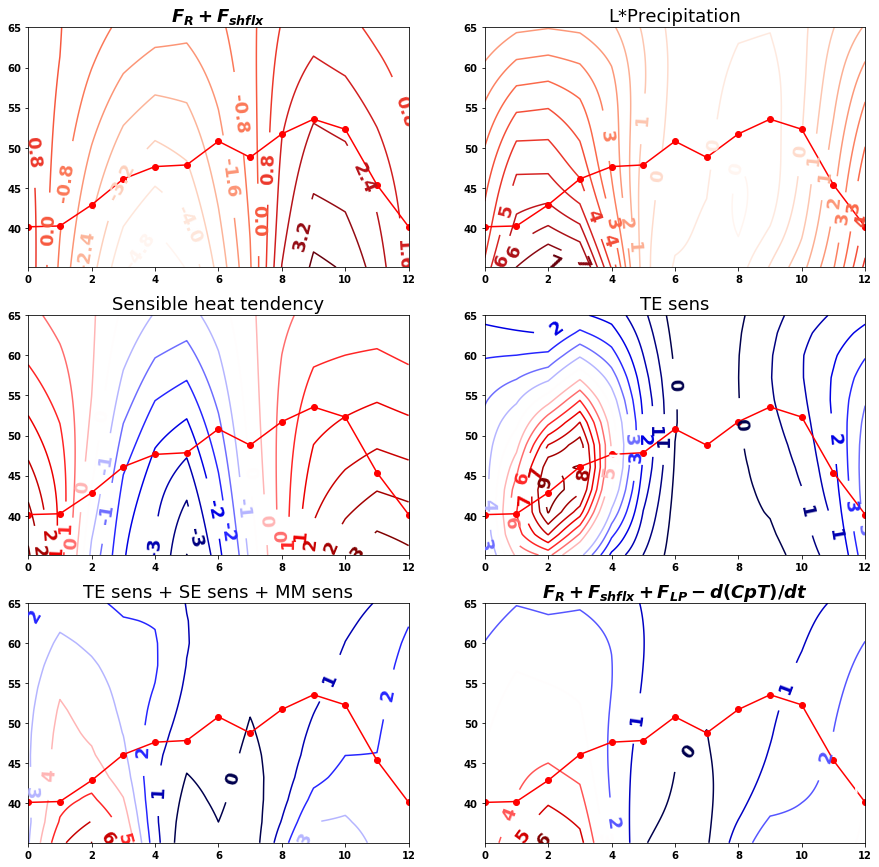

In [178]:
py.figure(figsize=(15,15))
d=0
py.subplot(3,2,1)
l_range=((latr_a>=35) & (latr_a<=65)) 
l_range1=((lat_a>=35) & (lat_a<=65)) 
c=py.contour(range(13),latr_a[l_range],((Iswabs_a + (Ishf_a - Ilhflx_a) - Iolr_a))[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title(r"$F_{R} + F_{shflx}$",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),latr_a[l_range],ILP_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L*Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),latr_a[l_range],(Idsensdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Sensible heat tendency",fontsize=18)

py.subplot(3,2,4)
c=py.contour(range(13),lat_a[l_range1],(ITE_dse_a)[d,l_range1,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("TE sens",fontsize=18)

py.subplot(3,2,5)
c=py.contour(range(13),lat_a[l_range1],((ITE_dse_a+ISE_dse_a+IMM_dse_a))[d,l_range1,:], cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("TE sens + SE sens + MM sens",fontsize=18)

py.subplot(3,2,6)
c=py.contour(range(13),latr_a[l_range],(((Iswabs_a + (Ishf_a - Ilhflx_a) - Iolr_a + ILP_a))-Idsensdt_a)[d,l_range,:],  cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title(r"$F_{R} + F_{shflx} + F_{LP} - d(CpT)/dt $",fontsize=18)

# py.subplot(3,2,6)
# c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a+div_MM_moist_a+div_SE_moist_a))[d,l_range,:],  15, cmap=cm.seismic); #py.colorbar()
# py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
# py.plot(storm_pos[d,:],'ro-')
# py.title("div(v(Lq))",fontsize=18)


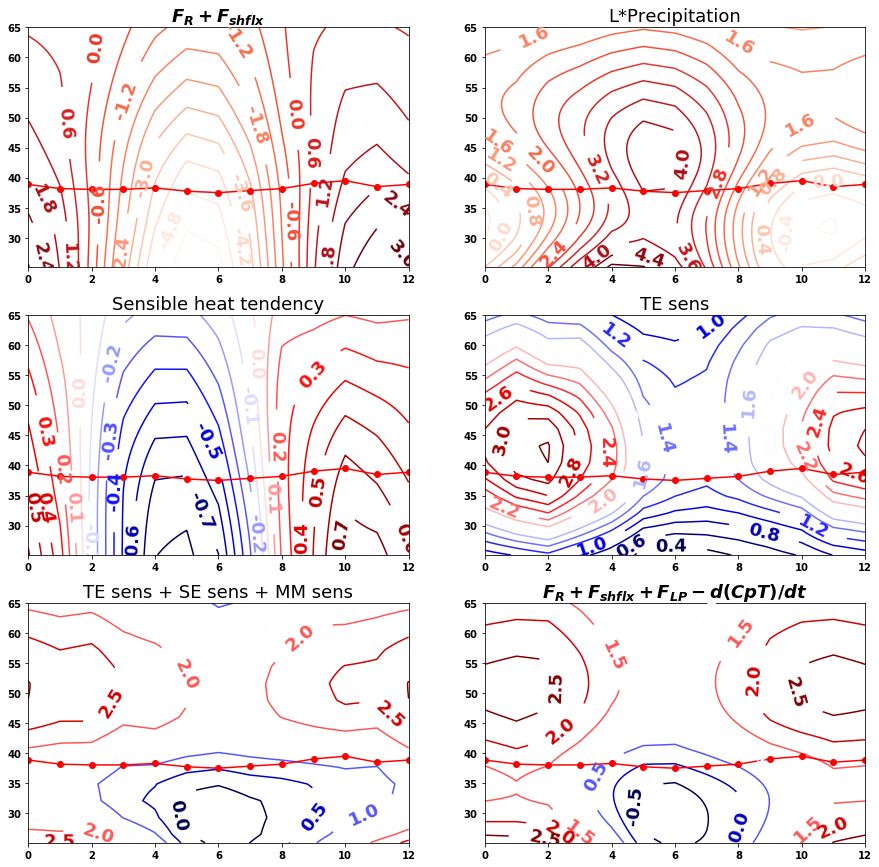

In [180]:
py.figure(figsize=(15,15))
d=1
py.subplot(3,2,1)
l_range=((latr_a>=25) & (latr_a<=65)) 
l_range1=((lat_a>=25) & (lat_a<=65)) 
c=py.contour(range(13),latr_a[l_range],((Iswabs_a + (Ishf_a - Ilhflx_a) - Iolr_a))[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title(r"$F_{R} + F_{shflx}$",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),latr_a[l_range],ILP_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L*Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),latr_a[l_range],(Idsensdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Sensible heat tendency",fontsize=18)

py.subplot(3,2,4)
c=py.contour(range(13),lat_a[l_range1],(ITE_dse_a)[d,l_range1,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("TE sens",fontsize=18)

py.subplot(3,2,5)
c=py.contour(range(13),lat_a[l_range1],((ITE_dse_a+ISE_dse_a+IMM_dse_a))[d,l_range1,:], cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("TE sens + SE sens + MM sens",fontsize=18)

py.subplot(3,2,6)
c=py.contour(range(13),latr_a[l_range],(((Iswabs_a + (Ishf_a - Ilhflx_a) - Iolr_a + ILP_a))-Idsensdt_a)[d,l_range,:],  cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title(r"$F_{R} + F_{shflx} + F_{LP} - d(CpT)/dt $",fontsize=18)

# py.subplot(3,2,6)
# c=py.contour(range(13),lat_a[l_range],((div_TE_moist_a+div_MM_moist_a+div_SE_moist_a))[d,l_range,:],  15, cmap=cm.seismic); #py.colorbar()
# py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
# py.plot(storm_pos[d,:],'ro-')
# py.title("div(v(Lq))",fontsize=18)


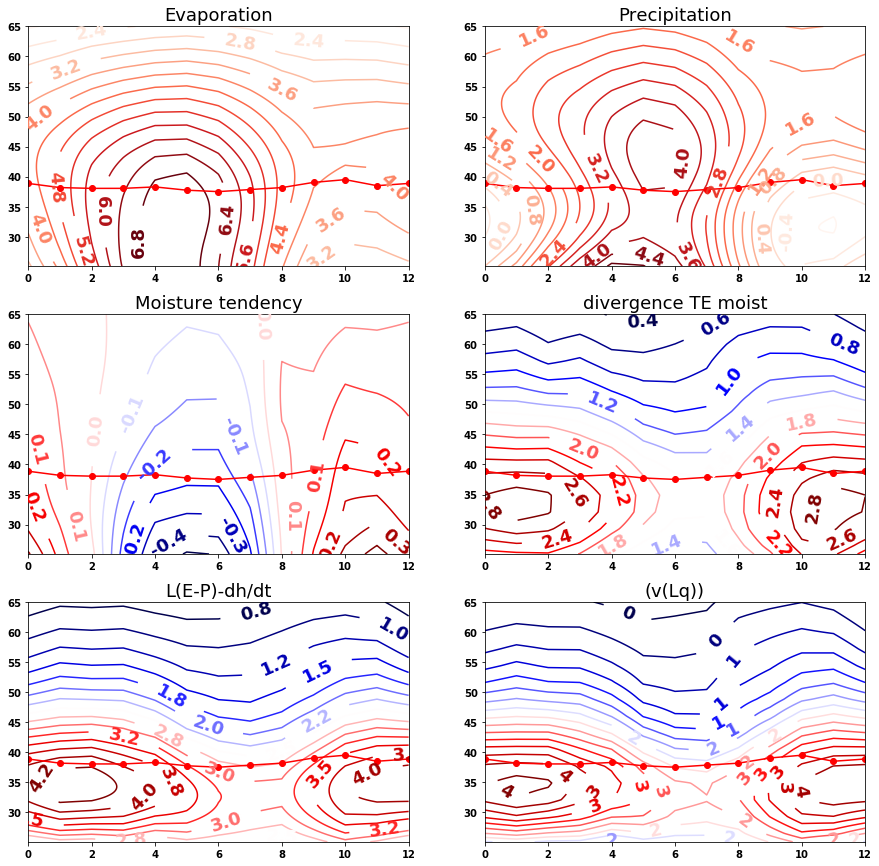

In [151]:
py.figure(figsize=(15,15))
d=1
py.subplot(3,2,1)
l_range=((latr_a>=25) & (latr_a<=65)) 
l_range1=((lat_a>=25) & (lat_a<=65)) 
c=py.contour(range(13),latr_a[l_range],Ilhflx_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Evaporation",fontsize=18)

py.subplot(3,2,2)
c=py.contour(range(13),latr_a[l_range],ILP_a[d,l_range,:], 15, cmap=cm.Reds); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Precipitation",fontsize=18)

py.subplot(3,2,3)
c=py.contour(range(13),latr_a[l_range],(Idmoistdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("Moisture tendency",fontsize=18)

py.subplot(3,2,4)
c=py.contour(range(13),lat_a[l_range1],((TE_moist_a))[d,l_range1,:],  15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("divergence TE moist",fontsize=18)

py.subplot(3,2,5)
c=py.contour(range(13),latr_a[l_range],(Ilhflx_a-ILP_a-Idmoistdt_a)[d,l_range,:], 15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("L(E-P)-dh/dt",fontsize=18)

py.subplot(3,2,6)
c=py.contour(range(13),lat_a[l_range1],((TE_moist_a+MM_moist_a+SE_moist_a))[d,l_range1,:],  15, cmap=cm.seismic); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.plot(storm_pos[d,:],'ro-')
py.title("(v(Lq))",fontsize=18)




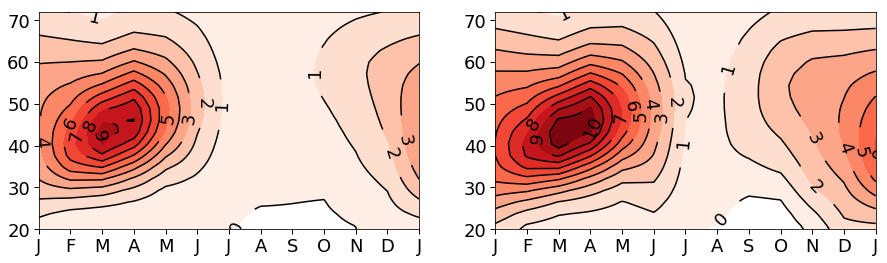

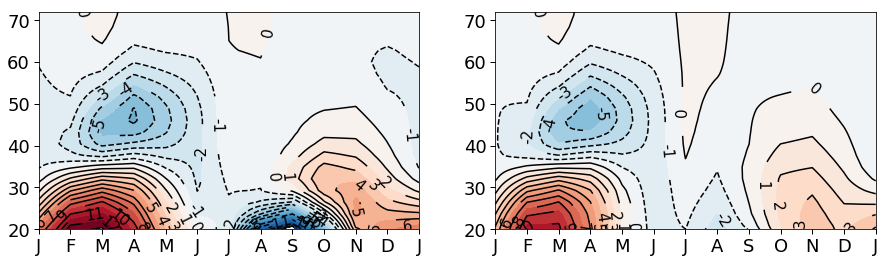

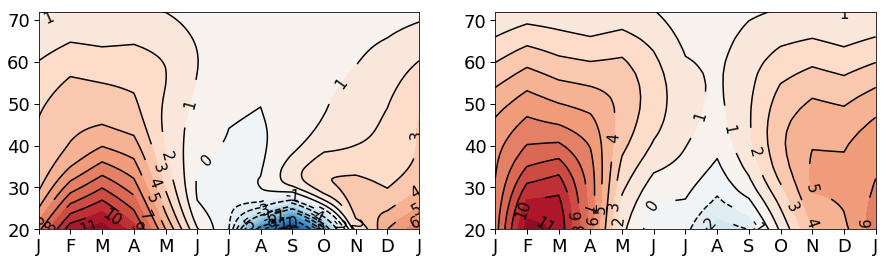

In [31]:
l1=200;l2=-150;
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
py.figure(figsize=(15,4))
d=0
py.subplot(1,2,1)
py.contourf(range(13),lat_a[l1:l2],ITE_dse_a[d,l1:l2,...], np.arange(0,12,1), cmap=cm.Reds); 
c=py.contour(range(13),lat_a[l1:l2],ITE_dse_a[d,l1:l2,...], np.arange(0,12,1), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos_dse[d,:], 'k.-')
py.subplot(1,2,2)
py.contourf(range(13),lat_a[l1:l2],TE_a[d,l1:l2,...], np.arange(0,12,1), cmap=cm.Reds); 
c=py.contour(range(13),lat_a[l1:l2],TE_a[d,l1:l2,...], np.arange(0,12,1), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=18)
# py.plot(range(13),storm_pos[d,:], 'k.-')
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)    

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.contourf(range(13),lat_a[l1:l2],IMM_dse_a[d,l1:l2,...], np.arange(-13,14,1), cmap=cm.RdBu_r); 
c=py.contour(range(13),lat_a[l1:l2],IMM_dse_a[d,l1:l2,...], np.arange(-13,14,1), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos_dse[d,:], 'k.-')
py.subplot(1,2,2)
py.contourf(range(13),lat_a[l1:l2],MM_a[d,l1:l2,...], np.arange(-13,14,1), cmap=cm.RdBu_r); 
c=py.contour(range(13),lat_a[l1:l2],MM_a[d,l1:l2,...], np.arange(-13,14,1), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1) 

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.contourf(range(13),latr_a[l1:l2],INE_dse_a[d,l1:l2,...], np.arange(-13,14,1), cmap=cm.RdBu_r); 
c=py.contour(range(13),latr_a[l1:l2],INE_dse_a[d,l1:l2,...], np.arange(-13,14,1), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos_dse[d,:], 'k.-')
py.subplot(1,2,2)
py.contourf(range(13),lat_a[l1:l2],NE_a[d,l1:l2,...], np.arange(-13,14,1), cmap=cm.RdBu_r); 
c=py.contour(range(13),lat_a[l1:l2],NE_a[d,l1:l2,...], np.arange(-13,14,1), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1d',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1) 


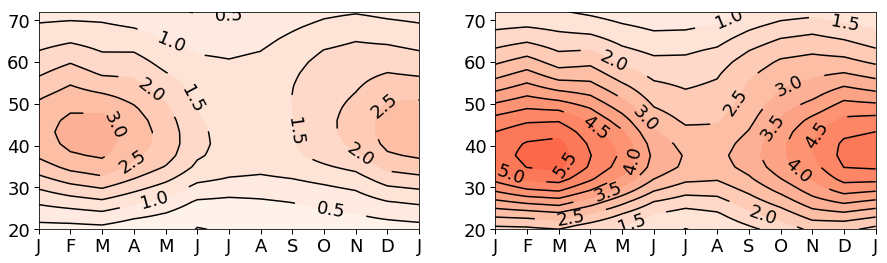

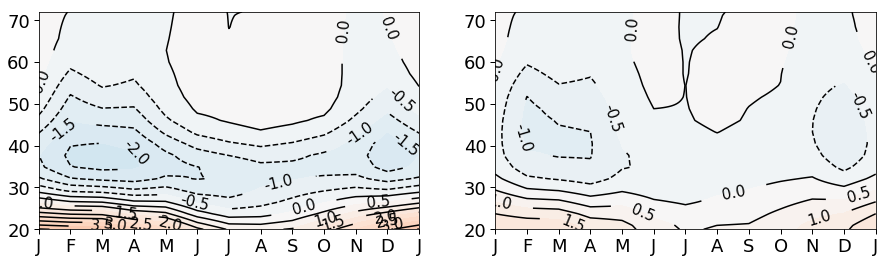

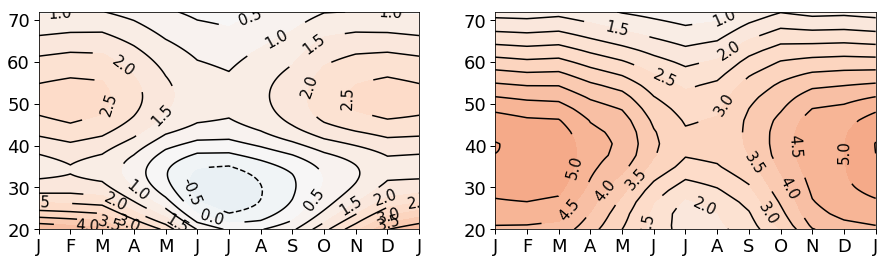

In [32]:
l1=200;l2=-150
py.figure(figsize=(15,4))
d=1
py.subplot(1,2,1)
py.contourf(range(13),lat_a[l1:l2],ITE_dse_a[d,l1:l2,...], np.arange(0,12,0.5), cmap=cm.Reds); 
c=py.contour(range(13),lat_a[l1:l2],ITE_dse_a[d,l1:l2,...], np.arange(0,12,0.5), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos_dse[d,:], 'k.-')
py.subplot(1,2,2)
py.contourf(range(13),lat_a[l1:l2],TE_a[d,l1:l2,...], np.arange(0,12,0.5), cmap=cm.Reds); 
c=py.contour(range(13),lat_a[l1:l2],TE_a[d,l1:l2,...], np.arange(0,12,0.5), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=18)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos[d,:], 'k.-')

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.contourf(range(13),lat_a[l1:l2],IMM_dse_a[d,l1:l2,...], np.arange(-13,14,0.5), cmap=cm.RdBu_r); 
c=py.contour(range(13),lat_a[l1:l2],IMM_dse_a[d,l1:l2,...], np.arange(-13,14,0.5), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos_dse[d,:], 'k.-')
py.subplot(1,2,2)
py.contourf(range(13),lat_a[l1:l2],MM_a[d,l1:l2,...], np.arange(-13,14,0.5), cmap=cm.RdBu_r); 
c=py.contour(range(13),lat_a[l1:l2],MM_a[d,l1:l2,...], np.arange(-13,14,0.5), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.contourf(range(13),latr_a[l1:l2],INE_dse_a[d,l1:l2,...], np.arange(-13,14,0.5), cmap=cm.RdBu_r); 
c=py.contour(range(13),latr_a[l1:l2],INE_dse_a[d,l1:l2,...], np.arange(-13,14,0.5), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)
# py.plot(range(13),storm_pos_dse[d,:], 'k.-')
py.subplot(1,2,2)
py.contourf(range(13),lat_a[l1:l2],NE_a[d,l1:l2,...], np.arange(-13,14,0.5), cmap=cm.RdBu_r); 
c=py.contour(range(13),lat_a[l1:l2],NE_a[d,l1:l2,...], np.arange(-13,14,0.5), colors="k"); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=15)
py.xticks(range(13), mticks,size=20)
py.tick_params(labelsize=18,size=5,width=1)



In [33]:
Intensity_te_dse=inerp_at_max(ITE_dse_a,lat_a,storm_pos_dse)
Intensity_se_dse=inerp_at_max(ISE_dse_a,lat_a,storm_pos_dse)
Intensity_mm_dse=inerp_at_max(IMM_dse_a,lat_a,storm_pos_dse)
Intensity_ne_dse=inerp_at_max(INE_dse_a,latr_a,storm_pos_dse)
Intensity_ne_dse1=inerp_at_max(INE_dse_a1,lat_a,storm_pos_dse)


I_SWAB    = inerp_at_max(Iswabs_a,latr_a,storm_pos_dse)
I_SHF_dse = inerp_at_max(Ishf_a-Ilhflx_a,latr_a,storm_pos_dse)
I_NE      = inerp_at_max(Ine_a,latr_a,storm_pos_dse)
I_OLR     = inerp_at_max(Iolr_a,latr_a,storm_pos_dse)
I_dhdt    = inerp_at_max(Idhdt_a,latr_a,storm_pos_dse)
I_dsdt    = inerp_at_max((Idsensdt_a),latr_a,storm_pos_dse)
I_LP      = inerp_at_max(ILP_a,latr_a,storm_pos_dse)


In [34]:
Intensity_te_dse.shape

(2, 13)

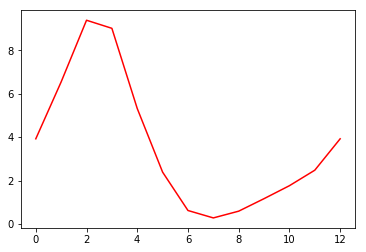

In [35]:
py.plot(Intensity_te_dse[0,:],'r-')

In [36]:
### radiation

def plot_intensity_dse(de,l,month_to_month=1):
    
    d=np.squeeze(np.where(np.array(depth_values)==de))
    print d
    depth=depth_values[d]
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
                  
    py.plot(D(Intensity_te_dse,d),'ro-',label=r'$\Delta I_{d}$',lw=3.5)
    py.plot(D(Intensity_ne_dse,d),'mo-',label=r'$\Delta I_{NE_{d}}$',lw=3.5)   
    py.plot(D(Intensity_ne_dse1,d),'mo--',label=r'$\Delta (I_{d}+I_{SE_{d}}+I_{MM_{d}})   $',lw=1.5)   
    py.plot(-D(Intensity_se_dse,d),'bo-',label=r'$ - \Delta I_{SE_{d}}$',lw=3.5)
    py.plot(-D(Intensity_mm_dse,d),'go-',label=r'$ - \Delta I_{MM_{d}}$',lw=3.5)
    
#     if de==50:
#         py.legend(loc="best",fontsize=29,ncol=2,frameon=False)
                                                     
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=37)
    title=""+" "+" "+str(depth_values[d])+"m"+ "  Intensity"
    title1="Intensity_decomposition_"+"_"+str(depth_values[d])+"m"
    py.title(title,fontsize=37,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)    
    py.tight_layout()

In [39]:
def compare_swabs_shf_olr(de,X,c,T,month_to_month=1,l=3, ylab=r'$PW$', ls='-'):
    
    d=np.squeeze(np.where(np.array(depth_values)==de))
    depth=depth_values[d]
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']            
    py.plot(range(13),D(X[d,:]),'o'+ls ,color=c,label=T,lw=3.5)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(ylab,fontsize=40)
#     if depth==50 :
#         py.legend(loc="best",fontsize=29,ncol=2,frameon=False)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(str(depth)+'m'+' Net energy',fontsize=37)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xlim(0,12)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)

1
0


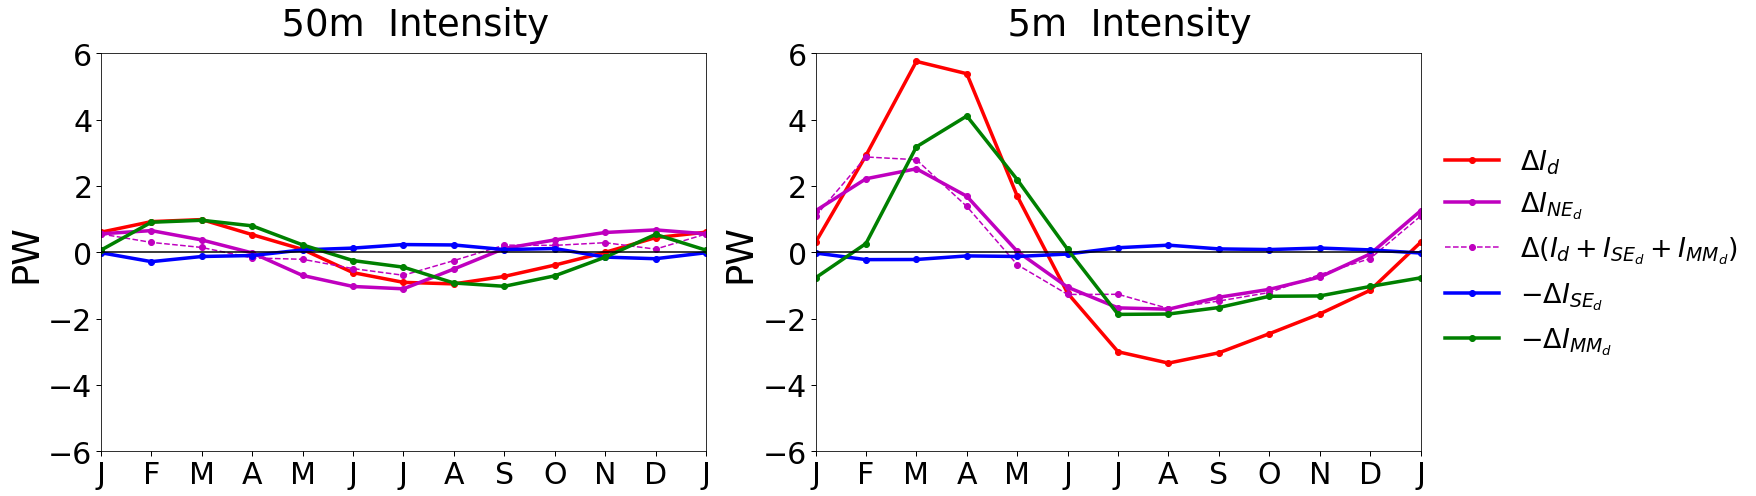

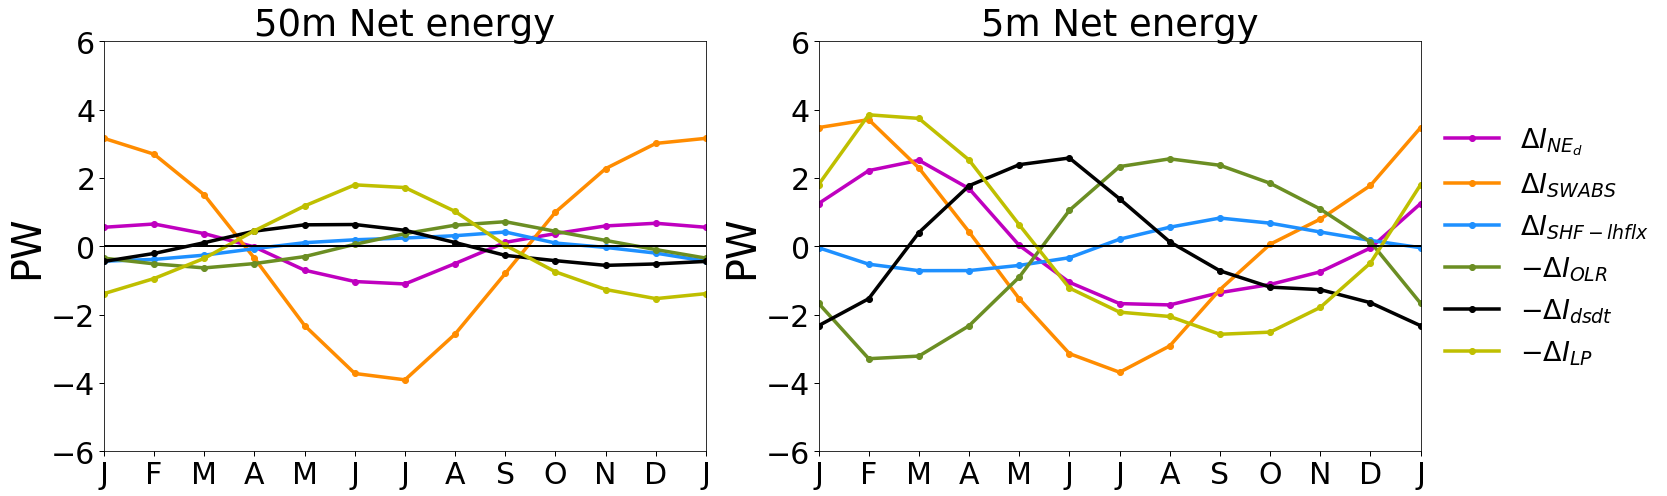

In [40]:
py.figure(figsize=(20,7))
i=0; l=6
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    plot_intensity_dse(d,6,0)
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)

py.tight_layout()
py.savefig('April10/DSE_Intensity_decomp.pdf',bbox_inches='tight')


py.figure(figsize=(20,7))
i=0; l=6
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    compare_swabs_shf_olr(d,Intensity_ne_dse,  'm',r'$\Delta I_{NE_d}$'      ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_SWAB,'darkorange',r'$\Delta I_{SWABS}$'  ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_SHF_dse, 'dodgerblue',r'$\Delta I_{SHF-lhflx}$'    ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,-I_OLR,'olivedrab',r'$-\Delta I_{OLR}$'     ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,-I_dsdt,'k',r'$-\Delta I_{dsdt}$'           ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_LP,'y',r'$-\Delta I_{LP}$'               ,month_to_month=0,l=6,ylab='PW')
#     compare_swabs_shf_olr(d,I_SWAB+I_SHF-I_OLR-I_dhdt,'c',r'$-\Delta I_{EIA}$'           ,month_to_month=0,l=6,ylab='PW')
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)
#     I_dhdt
py.tight_layout() 
# py.savefig('April10/DSE_net_energy_decomp.pdf',bbox_inches='tight')


In [41]:
def plot(d, te=14, se=14, mm=14):
    py.figure(figsize=(14,7));
    py.subplot(3,2,1)
    py.contourf(range(13), latr_a[300:-200], (Idhdt_a-IdLqdt_a)[d,300:-200,...],np.arange(-te,te+1,1), cmap=cm.RdBu_r); py.colorbar()
    py.subplot(3,2,2)
    py.contourf(range(13), latr_a[300:-200], (Idhdt_a)[d,300:-200,...],np.arange(-te,te+1,1), cmap=cm.RdBu_r); py.colorbar()

    py.subplot(3,2,3)
    py.contourf(range(13), lat_a[300:-200], ITE_dse_a[d,300:-200,...], np.arange(-se,se+1,0.2), cmap=cm.RdBu_r); py.colorbar()
    py.plot(storm_pos_dse[d,:],'ro--')
    py.subplot(3,2,4)
    py.contourf(range(13), lat_a[300:-200], TE_a[d,300:-200,...], np.arange(-se,se+1,1), cmap=cm.RdBu_r); py.colorbar()
    py.plot(storm_pos[d,:],'ro-')

    py.subplot(3,2,5)
    py.contourf(range(13), lat_a[300:-200], IMM_dse_a[d,300:-200,:], np.arange(-mm,mm+1,1), cmap=cm.RdBu_r); py.colorbar()
    py.subplot(3,2,6)
    py.contourf(range(13), lat_a[300:-200], MM_a[d,300:-200,:], np.arange(-mm,mm+1,1), cmap=cm.RdBu_r); py.colorbar()

    py.tight_layout()

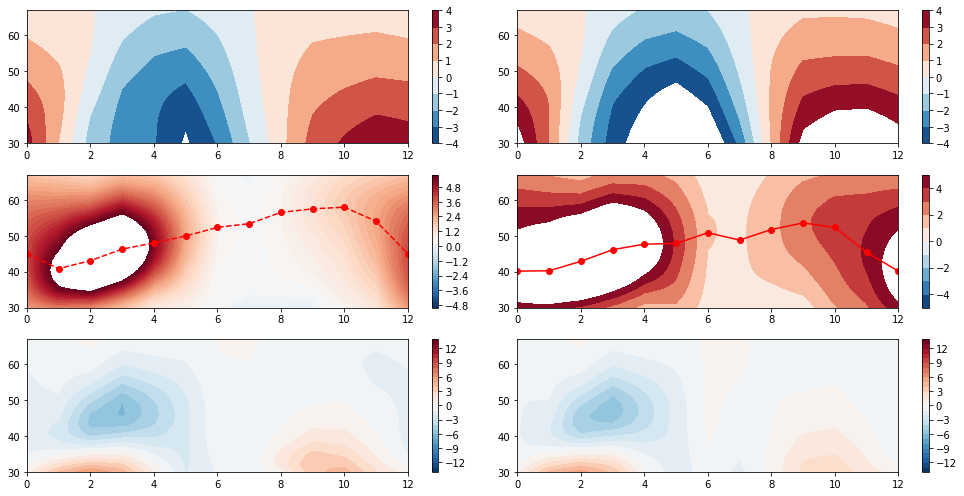

In [42]:
plot(0,4,5)

# Shift decompose

In [43]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    div_SE_a=spher_div(SE_a*10**15)
    div_MM_a=spher_div(MM_a*10**15)
    div_NE_a=div_TE_a+div_SE_a+div_MM_a
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [44]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=60))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(-1.0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [45]:
def threshold(I,value, pos1, pos2, pos3, pos4):
      for d in range(len(DEPTHS)):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                #N[d,m]=np.nan
                pos1[d,m]=np.nan
                pos2[d,m]=np.nan
                pos3[d,m]=np.nan
                pos4[d,m]=np.nan                
      return pos1, pos2, pos3, pos4
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, 0.0, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))

In [46]:
def plot_flux(d,threshold_value) :
    
    n=d+1
    pos=storm_pos
    
    mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),0)
    def add(y):
       y1 = y#np.append(y,y[:,0,np.newaxis],axis=1)
       y= np.roll(y,0,axis=-1)  
       return y
    
    def a(y):
       y1 = y#np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, threshold_value)
    latns=lat

    py.subplot(3,4,n)
    b = py.contourf(range(13),lat_a,add(TE_a[d,...]), v, cmap=BuRd); 
    c=py.contour(range(13),lat_a, add(TE_a[d,...]), v, colors='k',linewidths=1.0);    
    py.plot(range(13), np.roll((pos[d,:]),0), 'ro-')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-0,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth_values[d])+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.ylim(0,80)

In [47]:
# fig=py.figure(figsize=(20, 10))
# for d in range(len(DEPTHS)):
#     plot_flux(d,1.0)

# Decompose Net energy in Watts/m^2

In [48]:
swabs=np.array(swabs); shf=np.array(shf); ne=np.array(ne); olr=np.array(olr); dhdt=np.array(dhdt);
SW_sfc=np.array(SW_sfc); LW_sfc=np.array(LW_sfc); SW_toa=np.array(SW_toa); shflx=np.array(shflx); lhflx=np.array(lhflx);
sfc=np.array(sfc); toa=np.array(toa); 



In [49]:
SWABS_a, SHF_a  , FNE_a , OLR_a, dhdt_a, lat_a = N_S_avg( swabs,shf, ne ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#
sfc_a, toa_a = N_S_avg( sfc, toa, shflx, lhflx, LW_sfc, lat,flux_flag=1)[0:2]

In [50]:
def inerp_at_mean(flux,lat):
  D = np.zeros(((len(DEPTHS),13)))
  for d in range(0,(len(DEPTHS))):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=np.nanmean(zero_div_TE[d,:-1])
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [51]:
P_div_TE =inerp_at_mean(div_TE_a,lat_a)
P_div_SE =inerp_at_mean(div_SE_a,lat_a)
P_div_NE =inerp_at_mean(div_NE_a,lat_a)
P_div_MM =inerp_at_mean(div_MM_a,lat_a)

In [52]:
P_SWAB =inerp_at_max(SWABS_a,lat_a)
P_SHF  =inerp_at_max(SHF_a,lat_a)
P_NE   =inerp_at_max(FNE_a,lat_a)
P_OLR  =inerp_at_max(OLR_a,lat_a)
P_dhdt =inerp_at_max(dhdt_a,lat_a)

P_SWsfc = inerp_at_max(SW_sfc_a,lat_a)
P_LWsfc = inerp_at_max(LW_sfc_a,lat_a)
P_SWtoa = inerp_at_max(SW_toa_a,lat_a)
P_shflx = inerp_at_max(shflx_a,lat_a)
P_lhflx = inerp_at_max(lhflx_a,lat_a)

P_sfc = inerp_at_max(sfc_a,lat_a)
P_toa = inerp_at_max(toa_a,lat_a)

## Critical depth

In [53]:
d=4;i=0
file_loc="/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/"
file_loc2="/project2/tas1/pragallva/Summer_quarter_2018/post_process_data/"
rad_file= "zonal_radiation_dic.hkl"
smalat=(load(file_loc+'HC0_la'+str(d)+'m_oc'+str(d)+'m'+str(i)+'/'+"coord_dic.hkl"))["lat"]
swabs_all=[]
shf_all=[]
SWd_all=[]
olr_all=[]
N=10
def append_all(field,d):
    x=[]
    for i in range(N):
        x.append(load(file_loc+'HC0_la'+str(d)+'m_oc'+str(d)+'m'+str(i)+'/'+rad_file)[field])
    y= np.reshape( np.array(x), (12*N, 64))
    return y


def append2(field,d):
    x=[]
    for i in range(N):
        x.append(load(file_loc2+'seaice_isca_landice55_z0'+str(i)+'/'+rad_file)[field])
    y= np.reshape( np.array(x), (12*N, 64))
    return y

for d in depth_values:    
    if d==999:
        swabs_all.append(append2('SWABS',d))
        shf_all.append(append2('SHF',d))
        SWd_all.append(append2('SW_sfc_d',d))
        olr_all.append(append2('olr',d))
    else :
        swabs_all.append(append_all('SWABS',d))
        shf_all.append(append_all('SHF',d))
        SWd_all.append(append_all('SW_sfc_d',d))
        olr_all.append(append_all('olr',d))
    
def A(y): 
    y=np.array(y).transpose(0,2,1)
    return y#-y.mean(axis=1)[:,None,:]
swabs_all=A(swabs_all); shf_all=A(shf_all); SWd_all=A(SWd_all) ; olr_all=A(olr_all)

In [54]:
swabs_all_a, shf_all_a, SWd_all_a, olr_all_a, olr_all_a, smalat_a = \
N_S_avg( swabs_all, shf_all, SWd_all, olr_all, olr_all, smalat,flux_flag=1)#

In [55]:
from scipy.interpolate import interp1d
a= lambda x: np.append(x,x[...,0,None],axis=-1)
storm_pos_all=a(np.dstack([storm_pos[:,0:-1]]*N).transpose(0,2,1).reshape(len(DEPTHS),12*N))  ## I tried to remove the sea ice file from here
def all_at_max(flux,lat):
  D = np.zeros((flux.shape[0],12*N+1))
  for d in range(0,len(DEPTHS)):
    for m in range(0,12*N+1):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos_all
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [56]:
P_SWAB_all  =all_at_max(swabs_all_a,smalat_a)
P_SHF_all   =all_at_max(shf_all_a,smalat_a)
P_OLR_all   =all_at_max(olr_all_a,smalat_a)
P_SWtoa_all =all_at_max(SWd_all_a,smalat_a)

### Calculate phase difference

In [57]:
import numpy, scipy
from scipy.signal import correlate
def PHASE(X,Y):
  period=12.0
  delta= lambda x: (x-x[:].mean())/(x-x[:].mean()).std()
  lag=np.zeros(len(DEPTHS))
  
  for j in range(len(DEPTHS)):      
      A=delta(X[j,:]); B=delta(Y[j,:]);
      dt=np.arange(1-len(A),len(A))      
      xcorr=correlate(A,B)
      shift=dt[xcorr.argmax()]
      lag[j] = shift #2*np.pi*(((0.5 + shift/period) % 1.0) - 0.5)

#       py.figure(figsize=(15,20))
#       py.subplot(12,1,j+1)
#       py.plot(range(1,len(A)+1),A,'r-',label=r'$\Delta SWABS / std(\Delta SWABS)$')   
#       py.plot(range(1,len(B)+1),B,'b-',label='$\Delta SHF / std(\Delta SHF)$')   
#       if j==0: py.legend(loc=(0,1.01),fontsize=20)
#       py.title("depth= "+str(depth_values[j])+"m, lag ="+ str(lag[j])+" months",fontsize=20)
#       py.tight_layout()

  #phase=np.cos(2*np.pi*lag/period)
  phase= (2*np.pi*lag/period)
  return lag, phase
 
phase_swabs_shf=PHASE(P_SWAB_all,P_SHF_all)

lag   = phase_swabs_shf[0]
phase = phase_swabs_shf[1]

#### Calculate seasonal amplitude

In [58]:
def amp(X):
    A=np.zeros(len(DEPTHS))
    for d in range(len(DEPTHS)):
       A[d]=np.nanmax(X[d,:])-np.nanmin(X[d,:]) 
    return A

# Iamp=amp(Intensity_te)

##### Calculate e-folding depth 

In [59]:
from scipy.optimize import curve_fit

def efolding_depth(field,co='m'):

    def func(x, a, c, d):
        return a*np.exp(-c*x)+d
    x=depth_values[:-1]; y= amp(field)[:-1]
    popt, pcov = curve_fit(func, x, y, p0=(1, 1e-6, 1))
    xx= np.arange(1,100,1)
    e_depth = 1/popt[1] 
#     py.plot(x, y, co+'o')
#     py.plot(xx, func(xx, *popt), co+'-')
#     py.axvline(e_depth,color=co)
    return e_depth, xx, func(xx, *popt)
    

In [60]:
e_Pne   = efolding_depth(P_NE,'m')[0]
e_Polr  = efolding_depth(P_OLR,'g')[0]
e_Pdhdt = efolding_depth(P_dhdt,'k')[0]

amp_PNE_NH_SH = np.array([ 50.85997198,  24.14184012])

TypeError: Improper input: N=3 must not exceed M=1

# Diffusivity

In [ ]:
import numpy.ma as ma

threshold=0.001
mask_of_TE      = ma.masked_greater_equal(TEv_a, threshold)  ### Positive transient eddies
mask_of_div_MSE = ma.masked_less_equal(div_MSE, -1*threshold) ### Negative MSE gradient

not_mask_of_TE      = ma.masked_less(TEv_a, threshold)  ### Positive transient eddies
not_mask_of_div_MSE = ma.masked_greater(div_MSE, -1*threshold) ### Negative MSE gradient
masked_div_MSE = ma.masked_where( ma.getmask(not_mask_of_div_MSE) , div_MSE)
masked_TE      = ma.masked_where( ma.getmask(not_mask_of_TE), TEv_a)


In [ ]:
level=1
dm_by_dphi=masked_div_MSE[...,level,:]
not_mask_of_TE_a      = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
masked_TE_a      = ma.masked_where( ma.getmask(not_mask_of_TE_a), TE_a)
diffusivity_sfc= -TE_a/dm_by_dphi


def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_sfc)
Im_mean=mean(dm_by_dphi)
I_mean =mean(TE_a)

D_prime =prime(diffusivity_sfc)
Im_prime=prime(dm_by_dphi)
I_prime =prime(TE_a)

i1= mean(D_prime*Im_prime)
i1= (np.asarray( [np.squeeze(i1)]*13).transpose(1,2,0))
i2= -1*D_prime*Im_prime
i3= -1*D_prime*Im_mean
i4= -1*D_mean*Im_prime

i1_a=inerp_at_max(i1,lat_a)
i2_a=inerp_at_max(i2,lat_a)
i3_a=inerp_at_max(i3,lat_a)
i4_a=inerp_at_max(i4,lat_a)

#i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a=inerp_at_max(TE_prime,lat_a)


##### check Ray Pierrehumbert Figure 8

In [ ]:
# @hidden_cell
# from matplotlib import cm
# import matplotlib
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1000)
# rgba_color = cm.jet(norm(400),bytes=True) 

In [ ]:
# D_a          = inerp_at_max(diffusivity_sfc,lat_a)[:-1,:-1]
# dm_by_dphi_a = inerp_at_max(dm_by_dphi     ,lat_a)[:-1,:-1]
# color_index  = np.linspace(0.0,1.0,12)
# markershape= ["o", "v", "^", "*", "h", "+", "X",  "D", "d", "s", "P", ">"]

In [ ]:
# fig=py.figure(figsize=(12,7))
# for d in range(11):
#     for m in range(12):
#         py.plot( dm_by_dphi_a[d,m], D_a[d,m],  markershape[d], markersize=15, markeredgecolor='black', color=py.cm.jet(color_index[m]), label=str(depth_values[:-1][d]) )
# py.xlabel(r"dm/(a d$\phi$) (Jm/kg) ", fontsize=20)
# py.ylabel("Diffusivity ($10^{15} kg/(ms)$)", fontsize=20)
# py.tick_params(labelsize=18,size=4,width=2)

# bounds=[1,2,3,4,5,6,7,8,9,10,11,12]
# cmap = mpl.colors.ListedColormap(py.cm.jet(color_index))
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# ax1 = fig.add_axes([0.05, 1.00, 0.9, 0.15])
# cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
#                                 norm=norm,
#                                 ticks=bounds,  # optional
#                                 spacing='proportional',
#                                 orientation='horizontal')
# cb1.set_label('Months', fontsize=20)

# from matplotlib.lines import Line2D
# legend_elements = [ Line2D([0], [0], marker = markershape[i], color='k', label=depth_values[:-1][i], markersize=15) for i in range(11)]
# # ax2 = fig.add_axes()
# ax1.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.1, -5.5), fontsize=20)

In [ ]:
# cmap = mpl.colors.ListedColormap([color_index[i] for i in range(12)])


# Shift decomposition

In [ ]:
def check_depth(de):
    de_values=np.array(depth_values)
    d=np.squeeze(np.where((de_values)==de))
    return d

import numpy as np
def calculate_F_changes_from_depth_change(df,di):
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)

    def diff(x):
         return x[df,:,:]-x[di,:,:]
    base_pos=te[di,:,:]
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: x#np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

In [ ]:
def find_zero_for_depth_change(div, di, df,mm=0):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((months))

  for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=60))   
            if ( (df==1) & (m==9) & (mm==1) ):
                l_range=((lat_a>=47) & (lat_a<=60))
            elif ( (df==1) & (m==8) & (mm==1) ):
                l_range=((lat_a>=47) & (lat_a<=60))
            else :
                l_range=((lat_a>=30) & (lat_a<=60))
            interpolation_function = interp1d(div[l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[m]=np.nan        
  return zero_loc

def return_zeros(pos1, pos2, pos3, pos4, di, df):             
       return find_zero_for_depth_change(pos1,di, df), find_zero_for_depth_change(pos2,di, df, 1), find_zero_for_depth_change(pos3,di, df), find_zero_for_depth_change(pos4,di, df)   

    
    

In [ ]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(df,di,l,n) :

        
    df=check_depth(df)
    di=check_depth(di)
    
    SE_change, MM_change, TE_change, NE_change = calculate_F_changes_from_depth_change(df,di)
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = return_zeros((TE_change), (SE_change), (MM_change), (NE_change), di, df)
        
    n=d+1      
    m=range(0,13)
   
    def add_month_to_end(y1) :
        y=y1#np.append(y1[-1],y1)
        return y
        

    s=div_TE_a[di,:,:][None,:,:]
    base_pos=storm_pos[di,:]
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

    TE_obs_pos         = add_month_to_end(zero_div_TE-base_pos)
    SE_pos             = add_month_to_end(zero_div_SE-base_pos)
    MM_pos             = add_month_to_end(zero_div_MM-base_pos)
    NE_pos             = add_month_to_end(zero_div_NE-base_pos)
    TE_calc_pos        = SE_pos+MM_pos+NE_pos
    nonlinear_error= TE_obs_pos-TE_calc_pos
    
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi$',linewidth=3.5,markersize=20)
    fig=py.plot(SE_pos,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(MM_pos,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(NE_pos,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)
    
    #title="shift decomposition"+" "+" ("+str(depth)+"m)"
    title1=str(depth_values[df])+r"$m - $"+str(depth_values[di])+r"$ m$"
    py.title(title1,fontsize=40,y=1.03)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()


In [ ]:
df=check_depth(5)
di=check_depth(10)
SE_change, MM_change, TE_change, NE_change = calculate_F_changes_from_depth_change(df,di)
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = return_zeros((TE_change), (SE_change), (MM_change), (NE_change), di, df)

In [ ]:
fig=py.figure(figsize=(20, 7))
py.subplot(1,2,1)
plot_monthly_shift(df=5,di=10,l=20,n=0)
py.subplot(1,2,2)
plot_monthly_shift(df=10,di=50,l=10*2,n=2)
# py.subplot(2,2,4)
# plot_monthly_shift(df=50,di=100,l=20,n=3)
# py.savefig('/project2/tas1/pragallva/Summer_quarter_2018/figures/Isca/shift_diff_betw_depths.pdf')

# First figure

In [ ]:
amp_PNE_NH_SH = np.array([ 50.85997198,  24.14184012])

def amp(X):
    A=np.zeros(len(DEPTHS))
    for d in range(len(DEPTHS)):
       A[d]=np.nanmax(X[d,:])-np.nanmin(X[d,:]) 
    return A


py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(14,8))
ax1 = py.subplot(2,1,1) 
color = 'm'
# ax1.set_xlabel('Mixed layer depth')
ax1.set_ylabel(r"$Wm^{-2}$", fontsize=25, color=color)
ax1.plot(depth_values[:-1],amp(P_NE)[:-1],'o-',color=color, lw=2.5,mfc='none',markersize=15,label=r'$\Delta F_{NE}$'); 
# ax1.plot(efolding_depth(P_NE)[1], efolding_depth(P_NE)[2], 'm-', lw=2.5,mfc='none',markersize=15,label=r'$\Delta F_{NE}$ exp fit')
# ax1.hlines(y=amp_PNE_NH_SH[0],color='r',xmin=-5, xmax=5)
# ax1.hlines(y=amp_PNE_NH_SH[1],color='b',xmin=-5, xmax=5)

ax1.scatter(-1, amp_PNE_NH_SH[0], marker=">", s=200, c='y')
ax1.scatter(-1, amp_PNE_NH_SH[1], marker=">", s=200, c='c')

ax1.tick_params(axis='y', labelcolor=color, labelsize=20, size=4, width=2)
ax1.set_xticks(depth_values[:-1])
ax1.tick_params(axis='x', labelsize=20,size=4,width=2)
ax1.set_xlim(-2,110)
py.legend(loc='lower right',fontsize=25,frameon=False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'r'
ax2.set_ylabel(r"$Wm^{-2}$", fontsize=25, color=color, x=2.0)  # we already handled the x-label with ax1
ax2.plot(depth_values[:-1],amp(P_sfc)[:-1],'s-',color='b', lw=2.0,mfc='none',markersize=12,label=r'$\Delta F_{SFC}$'); 
ax2.plot(depth_values[:-1],amp(P_toa)[:-1],'o-',color='r', lw=2.5,mfc='none',markersize=15,label=r'$\Delta F_{TOA}$'); 
ax2.tick_params(axis='y', labelcolor=color, labelsize=20, size=4, width=2 )
ax2.tick_params(axis='x', labelsize=20,size=4,width=2)
ax2.set_xlim(-2,110)
py.legend(loc='best',ncol= 2,fontsize=25,frameon=False)
py.ylim(120,310)
py.title(r'$F_{NE}$ ,  '+r'$ F_{SFC}$,  '+ r'$ F_{TOA}$'  +' seasonal amplitude', fontsize=25)

py.tight_layout()  # otherwise the right y-label is slightly clipped


ax3 = py.subplot(2,1,2)
ax3.plot(depth_values[:-1],-lag[:-1],'ko-',lw=2.5,mfc='none',markersize=15);
ax3.scatter(-1, 0, marker=">", s=200, c='y')
ax3.scatter(-1, 6, marker=">", s=200, c='c')
ax3.set_xlim(-2,110)
py.ylim(-1,7)
py.xticks(depth_values[:-1])
py.tick_params(labelsize=20,size=4,width=2)
py.ylabel('months', fontsize=25)
py.xlabel("Mixed layer depth", fontsize=25)
py.title('Phase lag between SWABS and SHF', fontsize=25)

py.tight_layout()

# py.savefig('Jan28/critical_depth.pdf')
py.show()

In [61]:
amp_PNE_NH_SH = np.array([ 50.85997198,  24.14184012])

def amp(X):
    A=np.zeros(len(DEPTHS))
    for d in range(len(DEPTHS)):
       A[d]=np.nanmax(X[d,:])-np.nanmin(X[d,:]) 
    return A


py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(14,15))


py.subplot(3,1,1) 
color = 'r'
py.ylabel(r"$Wm^{-2}$", fontsize=25, color='k', x=2.0)  # we already handled the x-label with ax1
py.plot(depth_values[:-1],amp(P_sfc)[:-1],'s-',color='b', lw=2.0,mfc='none',markersize=12,label=r'$\Delta F_{SFC}$'); 
py.plot(depth_values[:-1],amp(P_toa)[:-1],'o-',color='r', lw=2.5,mfc='none',markersize=15,label=r'$\Delta F_{TOA}$'); 
py.tick_params(axis='y', labelcolor='k', labelsize=20, size=4, width=2 )
py.tick_params(axis='x', labelsize=20,size=4,width=2)
py.xlim(-2,105)
py.legend(loc='best',ncol= 2,fontsize=25,frameon=False)
py.ylim(120,310)
py.title(r'$ F_{SFC}$,  '+ r'$ F_{TOA}$'  +' seasonal amplitude', fontsize=25)
py.xticks(depth_values[:-1])
py.tight_layout()  # otherwise the right y-label is slightly clipped


py.subplot(3,1,2) 
color = 'm'
# ax1.set_xlabel('Mixed layer depth')
py.ylabel(r"$Wm^{-2}$", fontsize=25, color='k')
py.plot(depth_values[:-1],amp(P_NE)[:-1],'o-',color=color, lw=2.5,mfc='none',markersize=15,label=r'$\Delta F_{NE}$'); 
py.scatter(-1, amp_PNE_NH_SH[0], marker=">", s=200, c='y')
py.scatter(-1, amp_PNE_NH_SH[1], marker=">", s=200, c='c')
py.tick_params(axis='y', labelcolor='k', labelsize=20, size=4, width=2)
py.xticks(depth_values[:-1])
py.tick_params(axis='x', labelsize=20,size=4,width=2)
py.xlim(-2,105)
py.legend(loc='upper right',fontsize=25,frameon=False)
py.title(r'$F_{NE}$ '+ 'seasonal amplitude', fontsize=25)



py.subplot(3,1,3)
py.plot(depth_values[:-1],-lag[:-1],'ko-',lw=2.5,mfc='none',markersize=15);
py.scatter(-1, 0, marker=">", s=200, c='y')
py.scatter(-1, 6, marker=">", s=200, c='c')
py.xlim(-2,105)
py.ylim(-1,7)
py.xticks(depth_values[:-1])
py.tick_params(labelsize=20,size=4,width=2)
py.ylabel('months', fontsize=25)
py.xlabel("Mixed layer depth", fontsize=25)
py.title('Phase lag between SWABS and SHF', fontsize=25)

py.tight_layout()

# py.savefig('Jan28/critical_depth.pdf')
py.show()

OSError: [Errno 2] No such file or directory: 'kpsewhich'

OSError: [Errno 2] No such file or directory: 'kpsewhich'

# Second figure

In [ ]:
def compare_sfc_toa_dhdt(de,X,c,T,month_to_month=1,l=3, ylab=r'$Wm^{-2}$', ls='-'):
    
    de_values=np.array(depth_values)
    d=np.squeeze(np.where((de_values)==de))
    depth=de_values[d]
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']            
    py.plot(range(13),D(X[d,:]),'o'+ls ,color=c,label=T,lw=3.5)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(ylab,fontsize=40)
    if depth==5 :
        py.legend(loc="best",fontsize=25,ncol=2,frameon=False)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(str(depth)+'m',fontsize=37)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xlim(0,12)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)

In [ ]:
py.figure(figsize=(20,7))
i=0; l=6
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    compare_sfc_toa_dhdt(d,P_toa,'r',r'$\Delta F_{TOA}$',month_to_month=0,l=150)
    compare_sfc_toa_dhdt(d,P_sfc,'b',r'$\Delta F_{SFC}$',month_to_month=0,l=150)
    compare_sfc_toa_dhdt(d,P_NE,'m', r'$\Delta F_{NE}$' ,month_to_month=0,l=150)
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)
py.tight_layout()
# py.savefig('Jan25/TOA_SFC_NE.pdf',bbox_inches='tight')

# Third figure

In [ ]:
py.figure(figsize=(20,7))
i=0; l=6
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    compare_sfc_toa_dhdt(d,P_SWAB,'darkorange',r'$\Delta F_{SWABS}$',month_to_month=0,l=50)
    compare_sfc_toa_dhdt(d,P_SHF,'dodgerblue',r'$\Delta F_{SHF}$',month_to_month=0,l=50)
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)
py.tight_layout()
# py.savefig('Jan25/swabs_shf.pdf',bbox_inches='tight')

# Fourth figure

In [ ]:
### radiation

def plot_intensity(de,l,month_to_month=1):
    
    d=np.squeeze(np.where(np.array(depth_values)==de))
    depth=depth_values[d]
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
                  
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=3.5)
    py.plot(D(Intensity_ne,d),'mo-',label=r'$\Delta I_{NE}$',lw=3.5)   
    py.plot(-D(Intensity_se,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=3.5)
    py.plot(-D(Intensity_mm,d),'go-',label=r'$ - \Delta I_{MM}$',lw=3.5)
    
#     if de==50:
#         py.legend(loc="best",fontsize=29,ncol=2,frameon=False)
                                                     
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=37)
    title=""+" "+" "+str(depth_values[d])+"m"+ "  Intensity"
    title1="Intensity_decomposition_"+"_"+str(depth_values[d])+"m"
    py.title(title,fontsize=37,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)    
    py.tight_layout()

In [38]:
def compare_swabs_shf_olr(de,X,c,T,month_to_month=1,l=3, ylab=r'$PW$', ls='-'):
    
    d=np.squeeze(np.where(np.array(depth_values)==de))
    depth=depth_values[d]
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']            
    py.plot(range(13),D(X[d,:]),'o'+ls ,color=c,label=T,lw=3.5)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(ylab,fontsize=40)
#     if depth==50 :
#         py.legend(loc="best",fontsize=29,ncol=2,frameon=False)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(str(depth)+'m'+' Net energy',fontsize=37)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xlim(0,12)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)

In [ ]:
py.figure(figsize=(20,7))
i=0; l=6
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    plot_intensity(d,6,0)
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)

py.tight_layout()
# py.savefig('Jan25/Intensity_decomp.pdf',bbox_inches='tight')


py.figure(figsize=(20,7))
i=0; l=6
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    compare_swabs_shf_olr(d,Intensity_ne,  'm',r'$\Delta I_{NE}$'      ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_SWAB,'darkorange',r'$\Delta I_{SWABS}$'  ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_SHF, 'dodgerblue',r'$\Delta I_{SHF}$'    ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,-I_OLR,'olivedrab',r'$-\Delta I_{OLR}$'     ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,-I_dhdt,'k',r'$-\Delta I_{dhdt}$'           ,month_to_month=0,l=6,ylab='PW')
#     compare_swabs_shf_olr(d,I_SWAB+I_SHF-I_OLR-I_dhdt,'c',r'$-\Delta I_{EIA}$'           ,month_to_month=0,l=6,ylab='PW')
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)
#     I_dhdt
py.tight_layout() 
# py.savefig('Jan25/net_energy_decomp.pdf',bbox_inches='tight')


# py.figure(figsize=(20,7))
# i=0; l=6
# for d in [50,5]:
#     i=i+1
#     py.subplot(1,2,i)
#     compare_swabs_shf_olr(d,I_SFC,'b',       r'$\Delta I_{SFC}$'      ,month_to_month=0,l=18,ylab='PW')
#     compare_swabs_shf_olr(d,I_TOA,'r',       r'$\Delta I_{TOA}$'        ,month_to_month=0,l=18,ylab='PW')
#     compare_swabs_shf_olr(d,Intensity_ne,'m',r'$\Delta I_{NE}$'  ,month_to_month=0,l=18,ylab='PW')
#     py.legend().set_visible(False)
#     if d==5:
#         py.legend(loc="best",fontsize=28,ncol=3,frameon=False)  
#     py.title(str(d)+'m'+' SFC and TOA',fontsize=37)
# py.tight_layout() 
# py.savefig('Jan9/Itoa_&_Isfc.pdf')

# Fifth figure 
## Sea ice NE decomposition

In [ ]:
py.figure(figsize=(20,7))
i=0; l=6
for d in [999]:
    i=i+1
    py.subplot(1,2,i)
    compare_swabs_shf_olr(d,Intensity_ne,  'm',r'$\Delta I_{NE}$'    ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_SWAB,        'darkorange',r'$\Delta I_{SWABS}$',month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,I_SHF,         'dodgerblue',r'$\Delta I_{SHF}$'   ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,-I_OLR,        'olivedrab',r'$-\Delta I_{OLR}$'   ,month_to_month=0,l=6,ylab='PW')
    compare_swabs_shf_olr(d,-I_dhdt,       'k',r'$-\Delta I_{dhdt}$'     ,month_to_month=0,l=6,ylab='PW')
    py.legend(loc="best",fontsize=29,ncol=2,frameon=False)
    if d==50:
        py.title('50m slab',fontsize=37)        
    if d==999:
        py.title('50m slab +'+' polar ice cap ',fontsize=37)
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)

py.tight_layout()
# py.savefig('Jan25/net_energy_with_polar_ice.pdf',bbox_inches='tight')

# Sixth figure

In [ ]:
def plot_at_storm_position(de,l,month_to_month=1):
    
    d=np.squeeze(np.where(np.array(depth_values)==de))
    depth=depth_values[d]
    
    I1   =r'$ ({\Delta D \Delta I_{m}})_{o}$'
    I2   =r'$-(\Delta D) (\Delta I_{m})$'
    I3   =r'$-(\Delta D) {I_{m_{o}}}$'
    I4   =r'$-{D_{o}} (\Delta I_{m})$'
    ISUM =r'$\Delta I =$ '+I1 +I2 +I3 +I4
    Iorig=r'$\Delta I =$' + r'$\Delta\langle[\overline{v^{\prime}m^{\prime}}]\rangle$'
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
#     def D(y,d):
#         return y[d,...]
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=3.5) 
    py.plot(D(i3_a,d),'ko-',label=I3,lw=3.5)
    py.plot(D(i4_a,d),'bo-',label=I4,lw=3.5)
        
#     py.plot(D(i1_a,d),'co-',label=r'$+$'+I1,lw=3.5)
#     py.plot(D(i2_a,d),'yo-',label=I2,lw=3.5)   
    
#     py.plot(D(i_a,d),'ro-',label=r'$\Delta I_{calc}$',lw=3.5) 
    #py.plot(D(teprime_a,d),'ro-',label=r'$\Delta I$',lw=3.5) 

                                              
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    py.title(title,fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
#     if de==50:        
#         py.legend(loc='best',fontsize=29,ncol=2,frameon=False)
    py.tight_layout()

In [ ]:
l=6.0; i=0;
py.figure(figsize=(20,7))
for d in [50,5]:
    i=i+1
    py.subplot(1,2,i)
    plot_at_storm_position(d,l,0)
    if d==5:
        py.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=27,ncol=1,frameon=False)
py.tight_layout()
# py.savefig('Jan25/diffusive_decomp.pdf',bbox_inches='tight')

# Seventh figure

In [ ]:
py.figure(figsize=(20,7))

py.subplot(1,2,2)
m=10
py.plot(lat_a,div_TE_a[3,:,m]-div_TE_a[-4,:,m],'r-',lw=3.5,label=r'$\Delta F_{TE}$')
py.plot(lat_a,div_MM_a[3,:,m]-div_MM_a[-4,:,m],'g-',lw=3.5,label=r'$\Delta F_{MM}$')
py.axvline(storm_pos[-4,m],color='k')
py.axhline(0)
py.xlim(30,50)
py.ylim(-45,45)
py.xticks([30,35,40,45,50])
py.xticks([30,35,40,45,50],size=37)
py.tick_params(labelsize=30,size=5,width=1)
py.xlabel('latitude',fontsize=40)
py.ylabel(r'$Wm^{-2}$',fontsize=40)
py.title('10m - 50m (Nov)',fontsize=40)
py.legend(loc='best',fontsize=29,frameon=False)


py.subplot(1,2,1)
m=7
py.plot(lat_a,div_TE_a[3,:,m]-div_TE_a[-4,:,m],'r-',lw=3.5,  label=r'$\Delta F_{TE}$')
py.plot(lat_a,div_NE_a[3,:,m]-div_NE_a[-4,:,m],'m-',lw=3.5, label=r'$\Delta F_{NE}$')
# py.plot(lat_a,div_MM_a[3,:,m]-div_MM_a[-4,:,m],'g-')
py.axvline(storm_pos[-4,m],color='k')
py.axhline(0)
py.xlim(30,50)
py.ylim(-45,45)
py.xticks([30,35,40,45,50],size=37)
py.tick_params(labelsize=30,size=5,width=1)
py.xlabel('latitude',fontsize=40)
py.ylabel(r'$Wm^{-2}$',fontsize=40)
py.title('10m - 50m (Aug)',fontsize=40)
py.legend(loc='best',fontsize=29,frameon=False)

py.tight_layout()
# py.savefig('Jan25/Shift_compensation.pdf')